# Optimización Multiobjetivo de la Planificación de Mantenimiento en Plantas Mineras mediante Algoritmos Evolutivos NSGA-II

---

##  Resumen General del Proyecto

Este proyecto desarrolla un **sistema avanzado de planificación y optimización del mantenimiento de una planta minera**, modelado como un problema **MRCPSP (Multi-Mode Resource Constrained Project Scheduling Problem)** y resuelto mediante **optimización multiobjetivo con NSGA-II**.

El modelo considera simultáneamente:

- ⏱️ **Minimización del makespan** (duración total del proyecto)
- 💰 **Minimización del costo total de ejecución**

A lo largo de **10 etapas estructuradas**, se construyó un flujo completo que incluye:

1.  Carga, validación y estructuración de datos del proyecto.
2.  Modelado formal del problema (tareas, precedencias, recursos y capacidades).
3.  Definición de cromosomas de prioridad como representación de soluciones.
4.  Generación de cronogramas factibles mediante un **SSGS multi-modo**.
5.  Evaluación de funciones objetivo (tiempo y costo).
6.  Construcción y análisis de la población inicial.
7.  Implementación completa del algoritmo evolutivo **NSGA-II**.
8.  Análisis del frente de Pareto, extremos y **knee point**, incluyendo su **Gantt representativo**.
9.  Análisis de sensibilidad de los parámetros evolutivos.
10. Comparación experimental contra una **heurística básica (SSGS)**.

El sistema final constituye un **motor de optimización multiobjetivo completo, reproducible y orientado a aplicaciones reales en minería**.

---

## Etapa 1: Carga y Verificación Inicial de Datos

En esta etapa se realiza la **preparación y validación inicial de la información base del proyecto**.  
No se ejecuta ningún algoritmo de planificación ni optimización; el objetivo es **asegurar que todos los datos estén correctamente cargados y estructurados**.

### 🎯 Objetivo

Garantizar que las **tareas, recursos, materiales y requerimientos** estén disponibles, completos y en un formato adecuado para las siguientes etapas del modelo.

### ⚙️ Actividades realizadas

- Configuración del entorno del proyecto y rutas de trabajo  
- Carga de archivos JSON con la información del proyecto  
- Consolidación de estructuras por bloques en listas planas  
- Verificación básica de integridad mediante un resumen de los datos cargados  

### 📊 Resultado

Al finalizar esta etapa, el proyecto cuenta con una **base de datos correctamente inicializada**, reduciendo el riesgo de errores en etapas posteriores y dejando el sistema **listo para la construcción del modelo y la ejecución de los algoritmos de planificación y optimización**.

In [1]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN GENERAL
# ============================================================
from collections import defaultdict
from typing import Dict, List, Any
import json
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Any
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# ============================================================
# DEFINICIÓN DE RUTAS DEL PROYECTO
# ============================================================
BASE_PATH = Path(r"C:\Users\P718169161\Desktop\Proyecto Mina UNI")
DATA_PATH = BASE_PATH / "data"

In [3]:
# ============================================================
# FUNCIÓN DE CARGA DE JSON
# ============================================================

def load_json(filename: str) -> Any:
    """
    Carga un archivo JSON desde la carpeta de datos del proyecto.

    Parámetros:
    ----------
    filename : str
        Nombre del archivo JSON (ej. 'tasks.json')

    Retorna:
    -------
    Any
        Contenido del archivo JSON convertido a estructura Python
    """
    path = DATA_PATH / filename

    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def flatten_by_key(blocks: list[dict], key: str) -> list[dict]:
    """
    Aplana una estructura por bloques (section → key)
    Ej: key = 'tasks', 'assignments', 'materials'
    """
    flat = []
    for block in blocks:
        flat.extend(block.get(key, []))
    return flat

In [4]:
# ============================================================
# CARGA DE DATOS
# ============================================================

# Información general del proyecto
metadata = load_json("metadata.json")
objectives = load_json("objectives.json")
assets = load_json("assets.json")

# ---- TAREAS ----
tasks_blocks = load_json("tasks.json")
tasks = flatten_by_key(tasks_blocks, "tasks")

# ---- RECURSOS RENOVABLES ----
human_resources = load_json("human_resources.json")
technical_resources = load_json("technical_resources.json")

# ---- MATERIALES NO RENOVABLES ----
materials = load_json("materials.json")

# ---- REQUERIMIENTOS POR TAREA ----
task_resource_blocks = load_json("task_resource_requirements.json")
task_resource_requirements = flatten_by_key(
    task_resource_blocks,
    "assignments"
)

task_material_blocks = load_json("task_material_requirements.json")
task_material_requirements = flatten_by_key(
    task_material_blocks,
    "materials"
)

# ---- INFORMACIÓN ADICIONAL ----
calendar = load_json("calendar.json")
constraints = load_json("constraints.json")
indirect_costs = load_json("indirect_costs.json")

In [5]:
# ============================================================
# RESUMEN INICIAL DEL PROBLEMA (CARGA INICIAL)
# ============================================================

print("\n" + "=" * 40)
print("RESUMEN INICIAL DEL PROBLEMA")
print("=" * 40)

print("Proyecto:", metadata.get("project_name", "No definido"))

print("\nDatos cargados:")
print(f"- Tareas               : {len(tasks)}")
print(f"- Recursos humanos     : {len(human_resources)}")
print(f"- Recursos técnicos    : {len(technical_resources)}")
print(f"- Materiales           : {len(materials)}")

print("=" * 40 + "\n")


RESUMEN INICIAL DEL PROBLEMA
Proyecto: Parada Mayor Planta Minera – Mantenimiento Integral Escala Industrial

Datos cargados:
- Tareas               : 120
- Recursos humanos     : 15
- Recursos técnicos    : 15
- Materiales           : 30



## Etapa 2: Construcción del Modelo y Estructuras del Problema (MRCPSP)

En esta etapa se realiza la **formalización computacional del problema de planificación**, construyendo todas las **estructuras internas necesarias** para que el algoritmo pueda razonar sobre tareas, recursos, materiales y restricciones.

Aquí **no se genera aún ningún cronograma**, ni se optimiza nada. El objetivo es **transformar los datos crudos en un modelo matemático computable**.

### 🎯 Objetivo

Construir los **índices y estructuras base del problema MRCPSP**, dejando el sistema listo para:
- Verificar factibilidad
- Generar schedules
- Evaluar soluciones
- Ejecutar algoritmos evolutivos

### ⚙️ Actividades realizadas

- Indexación de todas las tareas del proyecto y sus secciones
- Construcción del grafo de precedencias entre tareas
- Indexación de recursos renovables (humanos y técnicos)
- Construcción de la matriz de requerimientos de recursos por tarea
- Definición de capacidades globales de recursos con **apertura controlada** para permitir paralelismo real
- Indexación de materiales no renovables y sus consumos por tarea
- Construcción de un diccionario unificado (`indexes`) que centraliza todo el modelo
- El problema siga siendo **no trivial y verdaderamente combinatorio**

### 📊 Resultado

Al finalizar esta etapa, el proyecto cuenta con un **modelo MRCPSP completamente estructurado en memoria**, con:
- Todas las tareas, recursos y materiales indexados
- Todas las restricciones listas para ser evaluadas
- Una base sólida para generar cronogramas factibles y comenzar la optimización en las siguientes etapas.

In [6]:
from collections import defaultdict
from typing import Dict, List, Any


def build_indexes(
    tasks_blocks: List[Dict[str, Any]],
    human_resources: List[Dict[str, Any]],
    technical_resources: List[Dict[str, Any]],
    materials: List[Dict[str, Any]],
    task_resource_requirements: List[Dict[str, Any]],
    task_material_requirements: List[Dict[str, Any]],
) -> Dict[str, Any]:
    """
    Construye las estructuras base del problema MRCPSP.

    Versión MODIFICADA:
    - Se introducen capacidades de recursos ampliadas
    - Se habilita paralelismo real
    - El makespan deja de estar rígidamente fijado
    """

    # --------------------------------------------------------
    # TAREAS (con sección)
    # --------------------------------------------------------

    task_by_id = {}
    task_section = {}
    precedences = {}
    task_desc = {}

    for block in tasks_blocks:
        section = block["section"]
        for t in block["tasks"]:
            tid = t["task_id"]
            task_by_id[tid] = t
            task_section[tid] = section
            precedences[tid] = t.get("precedences", [])
            task_desc[tid] = t.get("task_name", "")

    # --------------------------------------------------------
    # RECURSOS RENOVABLES
    # --------------------------------------------------------

    resource_by_id = {
        r["resource_id"]: r
        for r in human_resources + technical_resources
    }

    # Requerimientos base por tarea
    resource_req_by_task = defaultdict(dict)

    for row in task_resource_requirements:
        tid = row["task_id"]
        rid = row["resource_id"]
        units = int(row["units_required"])
        resource_req_by_task[tid][rid] = units

    # --------------------------------------------------------
    # CAPACIDAD GLOBAL DE RECURSOS (CLAVE DEL CAMBIO)
    # --------------------------------------------------------
    # Regla NUEVA:
    # - Capacidad = max requerimiento observado * factor
    # - Garantiza paralelismo sin volver trivial el problema

    resource_capacity = {}

    for rid in resource_by_id:
        max_req = max(
            (resource_req_by_task[t].get(rid, 0) for t in resource_req_by_task),
            default=0
        )

        # Apertura controlada del problema
        resource_capacity[rid] = max(
            int(1.3 * max_req),   # apertura principal
            max_req + 1,          # buffer mínimo
            4                     # piso absoluto
        )


    # --------------------------------------------------------
    # MATERIALES NO RENOVABLES
    # --------------------------------------------------------

    material_by_id = {
        m["material_id"]: m
        for m in materials
    }

    material_req_by_task = defaultdict(dict)

    for row in task_material_requirements:
        tid = row["task_id"]
        mid = row["material_id"]
        units = int(row["units_required"])
        material_req_by_task[tid][mid] = units

    # --------------------------------------------------------
    # RETORNO CONSOLIDADO
    # --------------------------------------------------------

    return {
        # Tareas
        "task_by_id": task_by_id,
        "task_section": task_section,
        "precedences": precedences,
        "task_desc": task_desc,

        # Recursos
        "resource_by_id": resource_by_id,
        "resource_req_by_task": dict(resource_req_by_task),
        "resource_capacity": resource_capacity,

        # Materiales
        "material_by_id": material_by_id,
        "material_req_by_task": dict(material_req_by_task),

        # Alias compatible Etapa 5
        "req_mat": dict(material_req_by_task),
    }


In [7]:
indexes = build_indexes(
    tasks_blocks=tasks_blocks,
    human_resources=human_resources,
    technical_resources=technical_resources,
    materials=materials,
    task_resource_requirements=task_resource_requirements,
    task_material_requirements=task_material_requirements,
)

## Etapa 3: Validación del Cromosoma de Prioridades

En esta etapa se introduce formalmente el concepto de **cromosoma** dentro del modelo evolutivo. El cromosoma representa un **orden de prioridad de ejecución de las tareas**, que será utilizado posteriormente por el generador de cronogramas (SSGS) para construir un schedule factible.

Aquí **todavía no se construye el cronograma**, solo se valida que el cromosoma sea **estructuralmente correcto y coherente con el modelo**.

### 🎯 Objetivo

Verificar que un cromosoma:
- Contenga **todas las tareas del modelo**
- No tenga tareas repetidas ni faltantes
- No contenga identificadores inválidos
- Permita **analizar y detectar violaciones de precedencia**
- Esté listo para ser usado como entrada en la Etapa 4

### ⚙️ Actividades realizadas

- Validación estructural del cromosoma:
  - Verificación de longitud correcta
  - Detección de tareas faltantes o extra
  - Detección de duplicados
- Análisis de violaciones de precedencia:
  - Se comprueba si alguna tarea aparece antes que sus predecesoras
  - Se reportan ejemplos en caso de error
- Visualización del cromosoma:
  - Se grafica el orden de prioridad de las tareas
  - Las tareas que participan en violaciones de precedencia se resaltan en color diferente

### 🧬 Interpretación importante

En este modelo:
- El cromosoma **NO necesita respetar precedencias**
- Las precedencias se respetan **recién en la Etapa 4**, durante la construcción real del schedule
- Aquí solo se mide **qué tan “conflictivo” o “limpio” es el orden de prioridades propuesto**

Esto permite que el algoritmo evolutivo explore libremente el espacio de soluciones sin quedar restringido prematuramente.

### 📊 Resultado

Al finalizar esta etapa:
- Se garantiza que el cromosoma es **válido desde el punto de vista estructural**
- Se conoce si presenta **conflictos de precedencia**
- El cromosoma queda **apto para ser usado por el generador de schedules** en la Etapa 4.

In [8]:
# ------------------------------------------------------------
# Validación estructural del cromosoma
# ------------------------------------------------------------
def validate_chromosome(chromosome, task_by_id):
    task_ids = set(task_by_id.keys())
    chrom_list = list(chromosome)
    chrom_set = set(chrom_list)

    missing = task_ids - chrom_set
    extra = chrom_set - task_ids
    duplicates = [tid for tid, c in Counter(chrom_list).items() if c > 1]

    is_valid = (
        len(chrom_list) == len(task_ids)
        and not missing
        and not extra
        and not duplicates
    )

    return {
        "is_valid": is_valid,
        "n_tasks_model": len(task_ids),
        "n_genes": len(chrom_list),
        "missing": missing,
        "extra": extra,
        "duplicates": duplicates,
    }


# ------------------------------------------------------------
# Violaciones de precedencia (a nivel de prioridad)
# ------------------------------------------------------------
def precedence_violations(chromosome, precedences):
    pos = {tid: i for i, tid in enumerate(chromosome)}
    violations = []

    for task, preds in precedences.items():
        for p in preds:
            if pos.get(p, -1) > pos.get(task, -1):
                violations.append((p, task))

    return violations


# ------------------------------------------------------------
# Ejecución de la Etapa 3
# ------------------------------------------------------------
def run_stage_3(chromosome, indexes):
    task_by_id = indexes["task_by_id"]
    precedences = indexes["precedences"]
    task_desc = indexes["task_desc"]

    print("\n" + "=" * 55)
    print("ETAPA 3 – VALIDACIÓN DEL CROMOSOMA")
    print("=" * 55)

    # 1) Validación estructural
    struct = validate_chromosome(chromosome, task_by_id)

    print(f"Tareas del modelo : {struct['n_tasks_model']}")
    print(f"Genes cromosoma   : {struct['n_genes']}")

    if not struct["is_valid"]:
        print("Estado: CROMOSOMA INVÁLIDO")
        if struct["missing"]:
            print("  - Tareas faltantes :", sorted(struct["missing"]))
        if struct["extra"]:
            print("  - IDs desconocidos :", sorted(struct["extra"]))
        if struct["duplicates"]:
            print("  - Duplicados       :", struct["duplicates"])
        print("\nCorrija el cromosoma antes de continuar.")
        print("=" * 55)
        return

    print("Estado: CROMOSOMA VÁLIDO")

    # 2) Precedencias
    violations = precedence_violations(chromosome, precedences)

    print(f"Violaciones de precedencia: {len(violations)}")
    if violations:
        print("Ejemplos de violación:")
        for p, t in violations[:5]:
            print(f"- {p} ({task_desc[p]}) debe preceder a {t} ({task_desc[t]})")
    else:
        print("El orden respeta todas las precedencias")

    print("\nSalida lista para la Etapa 4 (generación de schedule factible)")
    print("=" * 55)


# ------------------------------------------------------------
# Ejemplo de cromosoma (prioridad inicial)
# ------------------------------------------------------------
chromosome = list(indexes["task_by_id"].keys())

run_stage_3(chromosome, indexes)


ETAPA 3 – VALIDACIÓN DEL CROMOSOMA
Tareas del modelo : 120
Genes cromosoma   : 120
Estado: CROMOSOMA VÁLIDO
Violaciones de precedencia: 0
El orden respeta todas las precedencias

Salida lista para la Etapa 4 (generación de schedule factible)


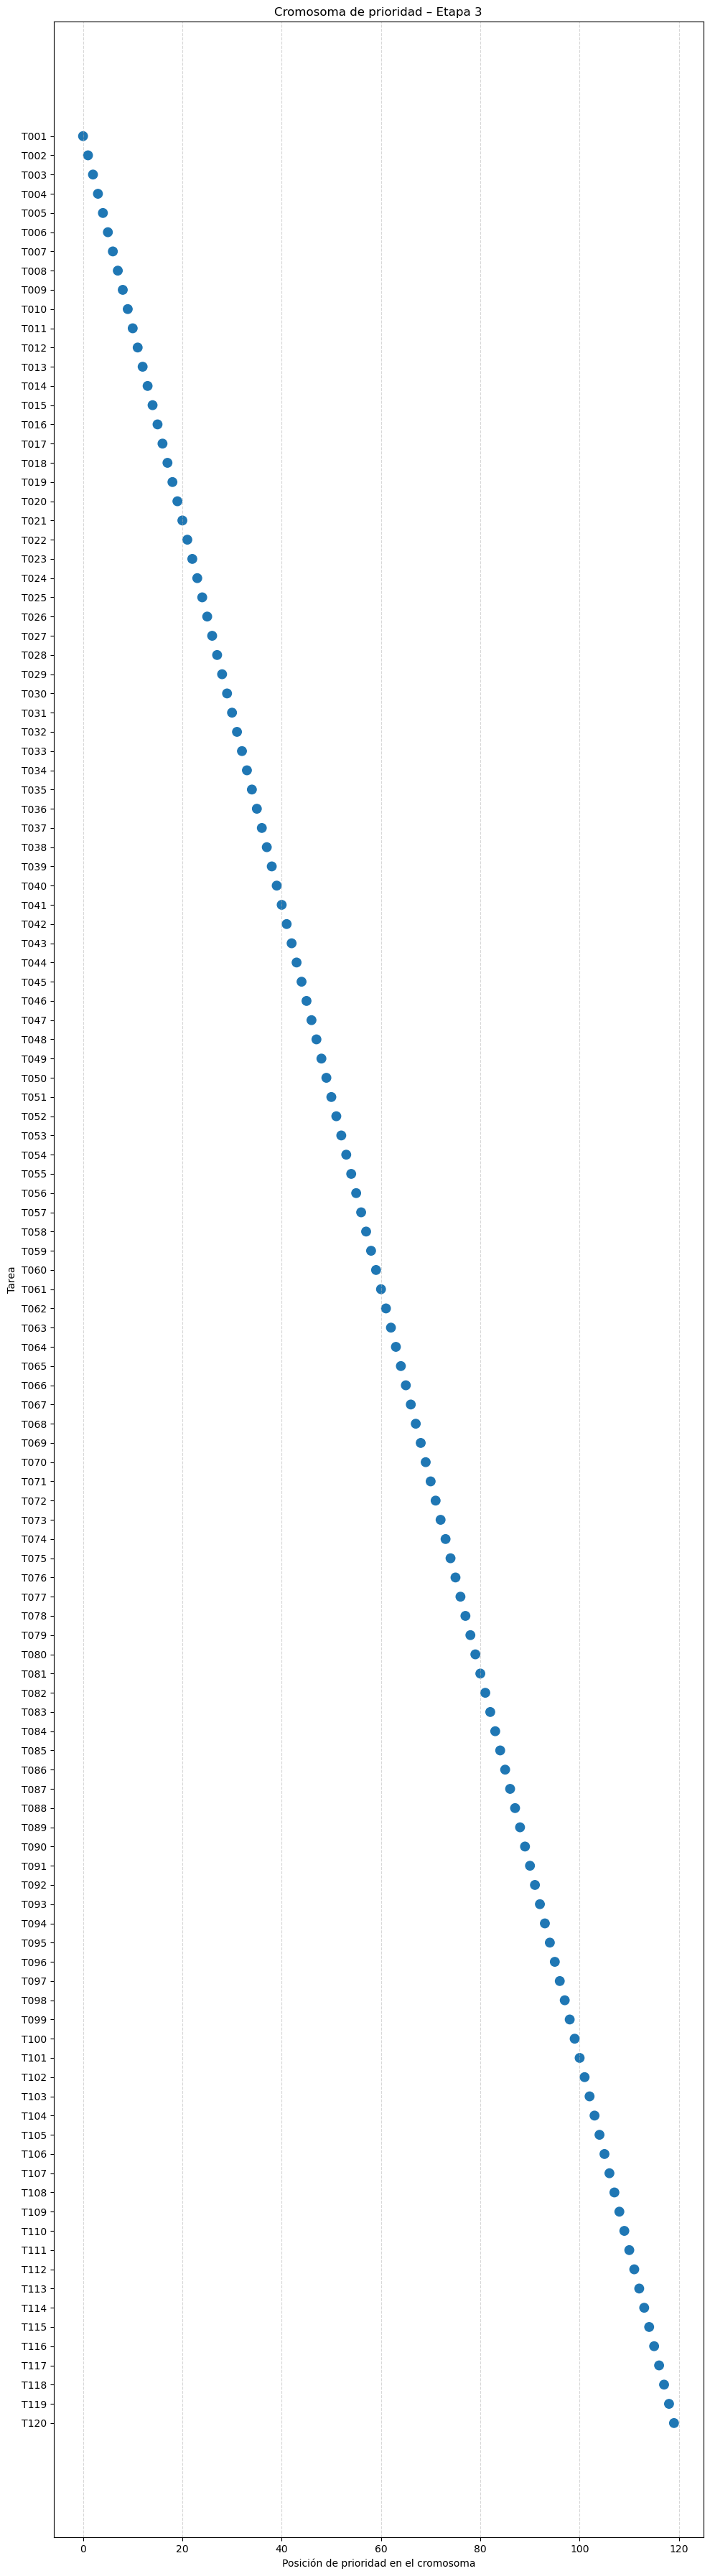

In [9]:
# ============================================================
# VISUALIZACIÓN DEL CROMOSOMA
# ============================================================
def plot_chromosome_priority(chromosome, indexes):
    precedences = indexes["precedences"]
    task_desc = indexes["task_desc"]

    # Posición real en el cromosoma
    pos = {tid: i for i, tid in enumerate(chromosome)}

    # Detectar tareas involucradas en violaciones de precedencia
    violating_tasks = set()
    for task, preds in precedences.items():
        for p in preds:
            if pos.get(p, -1) > pos.get(task, -1):
                violating_tasks.add(task)
                violating_tasks.add(p)

    # Datos para la gráfica
    x = [pos[tid] for tid in chromosome]          # prioridad
    y = list(range(len(chromosome)))              # índice visual
    labels = chromosome                           # IDs de tarea

    colors = [
        "tab:red" if tid in violating_tasks else "tab:blue"
        for tid in chromosome
    ]

    plt.figure(figsize=(10, max(4, len(chromosome) * 0.3)))
    plt.scatter(x, y, c=colors, s=80)

    plt.yticks(y, labels)
    plt.xlabel("Posición de prioridad en el cromosoma")
    plt.ylabel("Tarea")
    plt.title("Cromosoma de prioridad – Etapa 3")

    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------
# Ejecución
# ------------------------------------------------------------
plot_chromosome_priority(chromosome, indexes)

## Etapa 4: Generación del Cronograma Factible (SSGS – MRCPSP)

En esta etapa se implementa el **corazón operativo del modelo de planificación**: el algoritmo **SSGS (Serial Schedule Generation Scheme)** adaptado al problema **MRCPSP** (Multi-Mode Resource Constrained Project Scheduling Problem).

A partir de un **cromosoma de prioridades**, el sistema construye un **cronograma real y factible**, respetando:

- Precedencias tecnológicas
- Disponibilidad de recursos renovables
- Modos alternativos de ejecución por tarea
- Restricciones de capacidad de recursos

### 🎯 Objetivo

Transformar un **orden de prioridades abstracto (cromosoma)** en un:

- Cronograma **ejecutable en el mundo real**
- Que respete **todas las restricciones**
- Y produzca como salida un **makespan medible**

Este cronograma será luego evaluado en costos en la Etapa 5 y optimizado por NSGA-II en etapas posteriores.

### ⚙️ ¿Cómo funciona el SSGS?

El algoritmo opera de manera **iterativa en el tiempo**:

1. Parte del tiempo `t = 0`
2. Libera recursos de tareas ya finalizadas
3. Busca tareas:
   - No programadas
   - Con todas sus precedencias satisfechas
4. Para cada tarea elegible:
   - Prueba **modos de ejecución** (rápido, normal, económico, etc.)
   - Calcula requerimientos reales de recursos según el modo
   - Verifica factibilidad contra la capacidad disponible
5. Si encuentra un modo factible:
   - Programa la tarea
   - Reserva recursos
6. Si ninguna tarea puede iniciar:
   - Avanza el tiempo al próximo evento de finalización
7. Repite hasta programar **todas las tareas**

### 📊 Resultados generados

La etapa produce:

- Un **schedule completo** con:
  - Inicio de cada tarea
  - Fin de cada tarea
  - Modo usado
  - Duración
- El **makespan total del proyecto**
- Y una **visualización tipo Gantt** agrupada por secciones del proceso

Esta etapa es la **conexión directa entre genética y realidad operativa** del proyecto.

In [10]:
import random
import matplotlib.pyplot as plt

In [11]:
def generate_schedule_ssgs_mrcpsp(
    chromosome,
    indexes,
    rng,
    mode_top_k=3,
    mode_bias=0.7,
    max_steps=200000
):
    task_by_id = indexes["task_by_id"]
    precedences = indexes["precedences"]

    req_res = indexes["resource_req_by_task"]
    resource_capacity = indexes["resource_capacity"]

    time = 0.0
    scheduled = {}
    active = []
    available = dict(resource_capacity)

    def predecessors_done(tid):
        return all(p in scheduled for p in precedences.get(tid, []))

    def compute_req(tid, mode):
        base_req = req_res.get(tid, {})
        factor = float(mode.get("resource_factor", 1.0))
        return {r: int(round(base_req[r] * factor)) for r in base_req}

    def is_feasible(req):
        return all(available.get(r, 0) >= u for r, u in req.items())

    def pick_mode_candidates(task):
        modes = list(task["modes"])
        modes_sorted = sorted(modes, key=lambda m: m["duration_hours"])
        modes_top = modes_sorted[:max(1, min(mode_top_k, len(modes_sorted)))]

        # Genera un orden de prueba sesgado:
        # con prob mode_bias intenta primero el más rápido; si no, mezcla.
        if rng.random() < mode_bias:
            # rápido primero, luego el resto (de rápido a lento)
            return modes_top + [m for m in modes_sorted if m not in modes_top]
        else:
            shuffled = modes_top[:]
            rng.shuffle(shuffled)
            return shuffled + [m for m in modes_sorted if m not in modes_top]

    steps = 0

    while len(scheduled) < len(chromosome):
        steps += 1
        if steps > max_steps:
            raise RuntimeError("SSGS no converge")

        # Liberar tareas terminadas
        finished = [a for a in active if a["end"] <= time]
        for a in finished:
            for r, u in a["res"].items():
                available[r] += u
            active.remove(a)

        # Tareas elegibles
        eligible = [
            tid for tid in chromosome
            if tid not in scheduled and predecessors_done(tid)
        ]

        started = False

        # Intentar iniciar alguna tarea elegible
        for tid in eligible:
            task = task_by_id[tid]

            # Probar modos hasta encontrar uno factible
            chosen = None
            chosen_req = None
            for mode in pick_mode_candidates(task):
                req = compute_req(tid, mode)
                if is_feasible(req):
                    chosen = mode
                    chosen_req = req
                    break

            if chosen is None:
                continue  # esta tarea no puede iniciar ahora, probar otra

            start = time
            end = start + float(chosen["duration_hours"])

            for r, u in chosen_req.items():
                available[r] -= u

            scheduled[tid] = {
                "start": start,
                "end": end,
                "mode": chosen["mode_id"],
                "duration": float(chosen["duration_hours"]),
            }

            active.append({"end": end, "res": chosen_req})
            started = True
            break

        if not started:
            if active:
                time = min(a["end"] for a in active)
            else:
                # Diagnóstico: por qué no arrancó nadie en t=0
                sources = [tid for tid in chromosome if tid not in scheduled and not precedences.get(tid)]
                diag = []
                for tid in sources[:10]:
                    task = task_by_id[tid]
                    # calcula la menor demanda posible entre modos (eco suele ayudar)
                    best = None
                    best_mode = None
                    for mode in task["modes"]:
                        req = compute_req(tid, mode)
                        total_lack = sum(max(0, req[r] - available.get(r, 0)) for r in req)
                        if best is None or total_lack < best:
                            best = total_lack
                            best_mode = (mode["mode_id"], req)
                    if best_mode:
                        mode_id, req = best_mode
                        lacking = {r: req[r] - available.get(r, 0) for r in req if available.get(r, 0) < req[r]}
                        diag.append((tid, mode_id, lacking))

                raise RuntimeError(
                    "Schedule infactible real (precedencias o recursos). "
                    f"Ejemplos fuentes (task, modo_menos_exigente, faltantes): {diag}"
                )

    makespan = max(v["end"] for v in scheduled.values()) if scheduled else 0.0
    return {"schedule": scheduled, "makespan_hours": makespan}

In [12]:
def run_stage_4(indexes, seed=42, mode_top_k=3, mode_bias=0.7):
    rng = random.Random(seed)
    chromosome = list(indexes["task_by_id"].keys())
    rng.shuffle(chromosome)

    result = generate_schedule_ssgs_mrcpsp(
        chromosome=chromosome,
        indexes=indexes,
        rng=rng,
        mode_top_k=mode_top_k,
        mode_bias=mode_bias
    )
    return chromosome, result


chromosome, stage4_result = run_stage_4(indexes, seed=42, mode_top_k=3, mode_bias=0.7)

print("ETAPA 4 EJECUTADA CORRECTAMENTE")
print(f"Makespan: {stage4_result['makespan_hours']:.2f} horas")
print(f"Tareas programadas: {len(stage4_result['schedule'])}")

ETAPA 4 EJECUTADA CORRECTAMENTE
Makespan: 65.00 horas
Tareas programadas: 120


In [13]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

def plot_gantt_stage_4(result, indexes):
    sched = result["schedule"]
    task_section = indexes["task_section"]

    items = sorted(sched.items(), key=lambda x: x[1]["start"])

    # Secciones únicas
    sections = sorted({task_section[tid] for tid, _ in items})

    # Colormap moderno
    cmap = plt.colormaps.get_cmap("tab20").resampled(len(sections))
    section_color = {sec: cmap(i) for i, sec in enumerate(sections)}

    plt.figure(figsize=(12, max(4, len(items) * 0.25)))

    for i, (tid, d) in enumerate(items):
        sec = task_section[tid]
        plt.barh(
            i,
            d["duration"],
            left=d["start"],
            color=section_color[sec],
            edgecolor="black",
            linewidth=0.3
        )

    plt.yticks(range(len(items)), [tid for tid, _ in items])
    plt.xlabel("Tiempo (horas)")
    plt.title("Diagrama de Gantt – Etapa 4 (agrupado por sección)")
    plt.grid(axis="x", linestyle="--", alpha=0.4)

    # Leyenda agrupada
    legend_handles = [
        Patch(facecolor=section_color[sec], label=sec)
        for sec in sections
    ]
    plt.legend(handles=legend_handles, title="Sección")

    plt.tight_layout()
    plt.show()

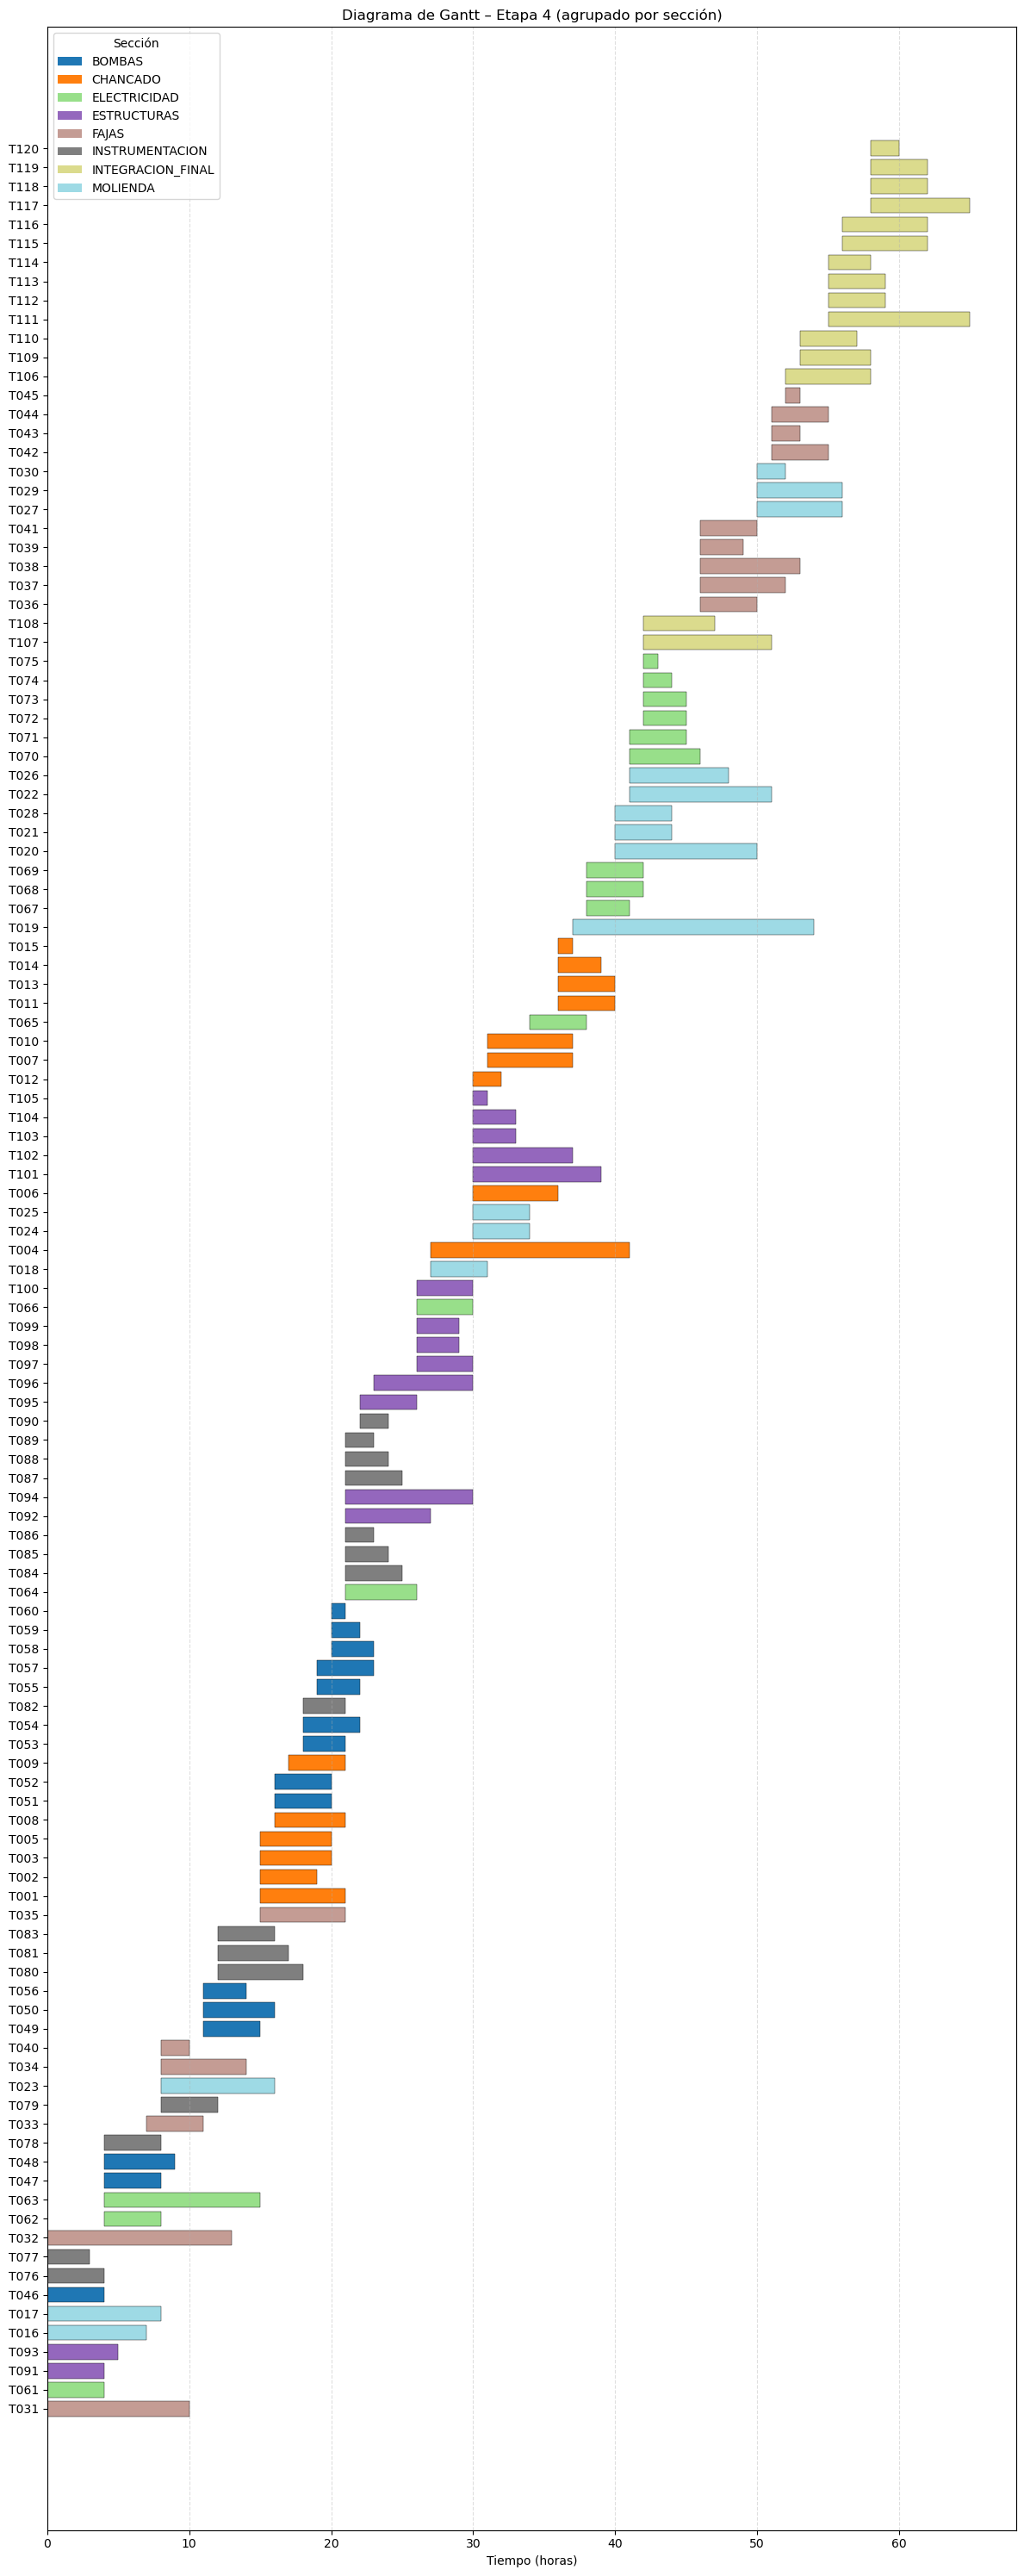

In [14]:
plot_gantt_stage_4(stage4_result, indexes)

## Etapa 5: Evaluación de Costos y Función Objetivo (MRCPSP)

En esta etapa, el cronograma factible generado en la **Etapa 4** deja de ser solo una solución en tiempo y se convierte en una **solución evaluable económicamente**. Aquí se define formalmente la **función objetivo multiobjetivo** del problema.

Cada cronograma es evaluado según:

- **f1:** Makespan total del proyecto (tiempo total)
- **f2:** Costo total del proyecto (recursos + materiales + costos indirectos + penalizaciones)

Esta evaluación es la que posteriormente utilizará **NSGA-II** para comparar, ordenar y optimizar soluciones.

### 🎯 Objetivo

Transformar un **schedule factible** en una **solución cuantificada** en términos de:

- **Tiempo total de ejecución**
- **Costo económico total del proyecto**

De esta forma, cada individuo del algoritmo evolutivo queda representado por un **par (makespan, costo)**.

### ⚙️ Componentes del modelo de costos

La evaluación considera cuatro componentes principales:

### 1) Costos directos de recursos

Para cada tarea programada:

- Se recorre **hora por hora** su ejecución
- Se aplica:
  - Costo por hora del recurso
  - Multiplicador por turno (día, tarde, noche)
  - Factor de consumo según el **modo de ejecución**

Esto permite modelar:

- Sobrecostos nocturnos
- Diferencias entre ejecutar rápido vs económico
- Uso parcial de algunos recursos especiales

### 2) Costos de materiales

- Los materiales son **no renovables**
- Su consumo se contabiliza **una sola vez por tarea**
- El costo se agrega directamente al costo total

### 3) Costos indirectos por tiempo

Se modela el costo estructural del proyecto como:

- Un **overhead por hora de proyecto**
- Proporcional al makespan total

Esto penaliza soluciones muy largas, incluso si usan pocos recursos.

### 4) Penalización por presión de recursos

Se introduce un término de penalización que:

- Compara la duración real vs duración nominal esperada
- Penaliza cronogramas excesivamente “comprimidos”
- Evita soluciones artificialmente cortas pero irrealistas en consumo

### 📊 Resultado

Al finalizar esta etapa:

- Cada cronograma ya es una **solución multiobjetivo completa**
- El sistema está listo para:
  - Generar poblaciones de soluciones
  - Aplicar selección evolutiva
  - Construir el frente de Pareto con NSGA-II


In [15]:
from collections import defaultdict
import matplotlib.pyplot as plt

# ============================================================
# MULTIPLICADOR POR TURNO
# ============================================================

def hour_multiplier(t):
    """
    Multiplicador por turno (hora absoluta):
    - 00–07 : noche
    - 08–17 : día
    - 18–23 : tarde
    """
    h = t % 24
    if 0 <= h <= 7:
        return 1.35
    if 8 <= h <= 17:
        return 1.00
    return 1.15


# ============================================================
# CONSTRUIR req_res BASE (independiente del modo)
# ============================================================

def build_req_res_base_from_task_resource(task_resource_blocks, resource_by_id):
    """
    Devuelve:
    req_res_base[task_id][resource_id] = units_required (clamped a capacidad)
    """
    req = defaultdict(dict)

    for block in task_resource_blocks:
        for a in block["assignments"]:
            tid = a["task_id"]
            rid = a["resource_id"]
            units = int(a["units_required"])
            cap = int(resource_by_id[rid]["capacity"])
            req[tid][rid] = min(units, cap)

    return dict(req)


# ============================================================
# COSTOS DIRECTOS (MRCPSP)
# ============================================================

def compute_costs_mrcpsp(
    schedule,
    indexes,
    req_res_base,
    partial_resources=None
):
    """
    Costos dependientes del schedule:
    - Recursos: hora a hora + multiplicador de turno
    - Materiales: consumo fijo
    """

    if partial_resources is None:
        partial_resources = {"RH05": 1}

    resource_by_id = indexes["resource_by_id"]
    material_by_id = indexes.get("material_by_id", {})
    req_mat = indexes.get("req_mat", {})

    # -----------------------------
    # 1) Costos de recursos
    # -----------------------------
    resource_cost = 0.0

    for task_id, info in schedule.items():
        #start = int(info["start"])
        #finish = int(info["finish"])
        #dur = finish - start
        start = int(info["start"])
        finish = int(info.get("finish", info["end"]))
        dur = finish - start


        # Factor por modo
        mode_factor = 1.0
        if "mode_index" in info:
            mode = indexes["task_by_id"][task_id]["modes"][info["mode_index"]]
            mode_factor = float(mode.get("resource_factor", 1.0))

        for rid, units in req_res_base.get(task_id, {}).items():
            cost_h = float(resource_by_id[rid]["cost_per_hour"])

            if rid in partial_resources:
                charged_hours = min(partial_resources[rid], dur)
                for t in range(start, start + charged_hours):
                    resource_cost += (
                        units * cost_h * hour_multiplier(t) * mode_factor
                    )
            else:
                for t in range(start, finish):
                    resource_cost += (
                        units * cost_h * hour_multiplier(t) * mode_factor
                    )

    # -----------------------------
    # 2) Costos de materiales
    # -----------------------------
    material_usage = defaultdict(float)
    for task_id in schedule:
        for mid, units in req_mat.get(task_id, {}).items():
            material_usage[mid] += units

    material_cost = sum(
        units * float(material_by_id[mid]["unit_cost"])
        for mid, units in material_usage.items()
    )

    direct_cost = resource_cost + material_cost

    return {
        "resource_cost": resource_cost,
        "material_cost": material_cost,
        "direct_cost": direct_cost
    }


# ============================================================
# DURACIÓN NOMINAL TOTAL (MRCPSP)
# ============================================================

def total_nominal_duration_mrcpsp(task_by_id):
    """
    Usa el promedio de duración de los modos por tarea
    """
    total = 0
    for t in task_by_id.values():
        modes = t["modes"]
        avg = sum(int(m["duration_hours"]) for m in modes) / len(modes)
        total += avg
    return total


# ============================================================
# ETAPA 5 – EVALUAR SOLUCIÓN DESDE SCHEDULE
# ============================================================

def evaluate_solution_stage5_mrcpsp(
    schedule_result,
    indexes,
    task_resource_blocks
):
    """
    f1 = makespan
    f2 = costo total
    """

    schedule = schedule_result["schedule"]
    makespan = int(schedule_result["makespan_hours"])

    # Recursos base
    req_res_base = build_req_res_base_from_task_resource(
        task_resource_blocks,
        indexes["resource_by_id"]
    )

    # -----------------------------
    # Costos directos
    # -----------------------------
    costs = compute_costs_mrcpsp(
        schedule=schedule,
        indexes=indexes,
        req_res_base=req_res_base,
        partial_resources={"RH05": 1}
    )

    direct_cost = costs["direct_cost"]

    # -----------------------------
    # Costos indirectos
    # -----------------------------
    overhead_per_hour = 500
    indirect_cost = overhead_per_hour * makespan

    # -----------------------------
    # Penalización por presión
    # -----------------------------
    nominal = total_nominal_duration_mrcpsp(indexes["task_by_id"])
    pressure_factor = nominal / max(1, makespan)
    resource_pressure_cost = direct_cost * 0.25 * pressure_factor

    # -----------------------------
    # Total
    # -----------------------------
    total_cost = direct_cost + indirect_cost + resource_pressure_cost

    return {
        "schedule": schedule,
        "makespan_hours": makespan,
        "costs": costs,
        "direct_cost": direct_cost,
        "indirect_cost": indirect_cost,
        "resource_pressure_cost": resource_pressure_cost,
        "total_cost": total_cost,
        "objectives": (makespan, total_cost)
    }


# ============================================================
# REPORTE ETAPA 5
# ============================================================

def stage5_report_mrcpsp(result):
    print("\n" + "=" * 70)
    print("ETAPA 5 – EVALUACIÓN DE COSTOS Y OBJETIVOS (MRCPSP)")
    print("=" * 70)

    print(f"Makespan (horas):            {result['makespan_hours']}")
    print(f"Costo directo:               {result['direct_cost']:.2f}")
    print(f"Costo indirecto (tiempo):    {result['indirect_cost']:.2f}")
    print(f"Penalización por recursos:   {result['resource_pressure_cost']:.2f}")
    print(f"COSTO TOTAL:                 {result['total_cost']:.2f}")

    print("\nDetalle costos directos:")
    print(f"- Recursos (por turnos):     {result['costs']['resource_cost']:.2f}")
    print(f"- Materiales:                {result['costs']['material_cost']:.2f}")

    print("\nObjetivos (NSGA-II):")
    print(f"f1 (makespan) = {result['objectives'][0]}")
    print(f"f2 (costo)    = {result['objectives'][1]:.2f}")

    print("=" * 70)
    print("ETAPA 5 COMPLETADA CORRECTAMENTE")
    print("=" * 70)


# ============================================================
# EJECUCIÓN (USANDO RESULTADO DE ETAPA 4)
# ============================================================

result_stage5 = evaluate_solution_stage5_mrcpsp(
    schedule_result=stage4_result,
    indexes=indexes,
    task_resource_blocks=task_resource_blocks
)

stage5_report_mrcpsp(result_stage5)


ETAPA 5 – EVALUACIÓN DE COSTOS Y OBJETIVOS (MRCPSP)
Makespan (horas):            65
Costo directo:               577349.75
Costo indirecto (tiempo):    32500.00
Penalización por recursos:   1515173.00
COSTO TOTAL:                 2125022.75

Detalle costos directos:
- Recursos (por turnos):     189349.75
- Materiales:                388000.00

Objetivos (NSGA-II):
f1 (makespan) = 65
f2 (costo)    = 2125022.75
ETAPA 5 COMPLETADA CORRECTAMENTE


In [16]:
def plot_pareto_point_stage5(result_stage5, label="Escenario base"):
    """
    Visualiza UN SOLO punto (makespan, costo) de la Etapa 5.
    Pensado para luego superponer otros escenarios.
    """

    makespan = result_stage5["makespan_hours"]
    cost = result_stage5["total_cost"]

    plt.figure(figsize=(7, 6))

    plt.scatter(
        makespan,
        cost,
        s=140,
        color="crimson",
        edgecolor="black",
        zorder=3
    )

    plt.xlabel("Makespan (horas)")
    plt.ylabel("Costo total")
    plt.title("Frente de Pareto – Etapa 5")

    plt.grid(True, linestyle="--", alpha=0.5)

    # Etiqueta del punto
    plt.annotate(
        f"{label}\n(M={makespan}, C={cost:,.0f})",
        (makespan, cost),
        textcoords="offset points",
        xytext=(10, 10),
        fontsize=10
    )

    plt.tight_layout()
    plt.show()

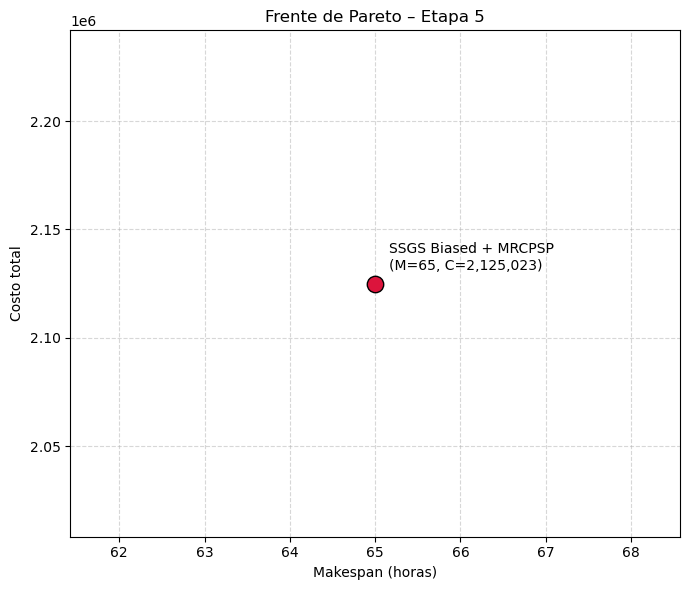

In [17]:
plot_pareto_point_stage5(
    result_stage5,
    label="SSGS Biased + MRCPSP"
)

## Etapa 6: Generación y Evaluación de la Población Inicial

En esta etapa se construye y analiza la **población inicial de soluciones** que servirá como punto de partida para el algoritmo evolutivo **NSGA-II**.

Cada individuo de la población es un **cromosoma** que representa un orden de prioridad de las tareas. Este cromosoma:

- Se transforma en un **schedule factible** usando la **Etapa 4 (SSGS MRCPSP)**  
- Luego se evalúa económicamente usando la **Etapa 5 (modelo de costos)**  

De esta forma, cada individuo queda representado por un par de objetivos:

- **f1:** Makespan del proyecto  
- **f2:** Costo total del proyecto  

### 🎯 Objetivo de la etapa

- Construir una **población inicial diversa y válida**
- Verificar que el sistema:
  - Puede generar schedules factibles
  - Puede evaluarlos correctamente en términos multiobjetivo
- Obtener una **primera fotografía del espacio de soluciones** del problema

### ⚙️ Proceso realizado

1. **Generación de cromosomas aleatorios**  
   Cada cromosoma es una **permutación completa de las tareas**, garantizando validez estructural.

2. **Construcción de la población inicial**  
   Se crean múltiples cromosomas independientes usando aleatoriedad controlada.

3. **Evaluación individual de cada solución**  
   Para cada cromosoma:
   - Se genera un schedule factible (Etapa 4)
   - Se calcula su makespan y su costo total (Etapa 5)

4. **Filtrado y registro de resultados**  
   - Las soluciones factibles se almacenan con sus objetivos
   - Las infactibles se registran solo para diagnóstico

5. **Análisis estadístico de la población**  
   Se reportan:
   - Valores mínimo, máximo y promedio de makespan
   - Valores mínimo, máximo y promedio de costo

### 📊 Resultado de la etapa

Al finalizar esta etapa se obtiene:

- Una **población inicial completamente evaluada**
- Evidencia de que existe:
  - Variabilidad real en tiempo
  - Variabilidad real en costo
- Confirmación de que:
  - El generador de schedules funciona correctamente
  - El modelo de costos es consistente

Al completar esta etapa, el sistema queda **listo para aplicar selección, cruce y mutación**, y comenzar la búsqueda evolutiva del **frente de Pareto óptimo**.

In [18]:
import random
import statistics

# ============================================================
# GENERAR CROMOSOMA ALEATORIO
# ============================================================

def random_chromosome(task_ids, rng):
    """
    Genera un cromosoma válido (permutación completa de tareas).
    """
    chrom = list(task_ids)
    rng.shuffle(chrom)
    return chrom


# ============================================================
# CONSTRUIR POBLACIÓN INICIAL
# ============================================================

def build_initial_population(indexes, pop_size=50, seed=42):
    """
    Construye la población inicial de cromosomas.
    """
    rng = random.Random(seed)
    task_ids = list(indexes["task_by_id"].keys())

    return [
        random_chromosome(task_ids, rng)
        for _ in range(pop_size)
    ]


# ============================================================
# EVALUAR UN INDIVIDUO (ETAPA 4 + ETAPA 5)
# ============================================================

def evaluate_individual(
    chromosome,
    indexes,
    task_resource_blocks,
    rng,
    mode_top_k=3,
    mode_bias=0.6,
):
    """
    Evalúa un cromosoma:
    1) Genera schedule factible (Etapa 4 – SSGS MRCPSP)
    2) Evalúa costos y objetivos (Etapa 5)
    """

    # -----------------------------
    # ETAPA 4 – GENERAR SCHEDULE
    # -----------------------------
    schedule_result = generate_schedule_ssgs_mrcpsp(
        chromosome=chromosome,
        indexes=indexes,
        rng=rng,
        mode_top_k=mode_top_k,
        mode_bias=mode_bias
    )

    # -----------------------------
    # ETAPA 5 – EVALUAR SOLUCIÓN
    # -----------------------------
    eval_result = evaluate_solution_stage5_mrcpsp(
        schedule_result=schedule_result,
        indexes=indexes,
        task_resource_blocks=task_resource_blocks
    )

    return eval_result


# ============================================================
# EVALUAR TODA LA POBLACIÓN
# ============================================================

def evaluate_population(
    population,
    indexes,
    task_resource_blocks,
    seed=123
):
    """
    Evalúa una población completa.
    Cada individuo usa su propio RNG para diversidad real.
    """
    evaluated = []
    base_rng = random.Random(seed)

    for chrom in population:
        rng_i = random.Random(base_rng.randint(0, 10**9))

        try:
            res = evaluate_individual(
                chromosome=chrom,
                indexes=indexes,
                task_resource_blocks=task_resource_blocks,
                rng=rng_i
            )

            evaluated.append({
                "chromosome": chrom,
                "valid": True,
                "objectives": res["objectives"],          # (makespan, total_cost)
                "makespan_hours": res["makespan_hours"],
                "total_cost": res["total_cost"],
                "details": res
            })

        except Exception as e:
            evaluated.append({
                "chromosome": chrom,
                "valid": False,
                "error": str(e)
            })

    return evaluated


# ============================================================
# RESUMEN EXPLICATIVO DE LA POBLACIÓN
# ============================================================

def stage6_summary(evaluated, show_top_errors=5):
    """
    Reporte explicativo de la población inicial evaluada.
    """
    valid = [e for e in evaluated if e["valid"]]
    invalid = [e for e in evaluated if not e["valid"]]

    print("\n" + "=" * 60)
    print("ETAPA 6 – ANÁLISIS DE LA POBLACIÓN INICIAL")
    print("=" * 60)
    print(f"Tamaño población total: {len(evaluated)}")
    print(f"Individuos válidos:     {len(valid)}")
    print(f"Individuos inválidos:   {len(invalid)}")

    if not valid:
        print("\nNo hay individuos válidos en la población.")
        if invalid:
            print("\nEjemplos de errores:")
            for e in invalid[:show_top_errors]:
                print("-", e["error"])
        print("=" * 60)
        return

    makespans = [e["objectives"][0] for e in valid]
    costs     = [e["objectives"][1] for e in valid]

    print("\n[Makespan]")
    print(f"- Mínimo   : {min(makespans)}")
    print(f"- Máximo   : {max(makespans)}")
    print(f"- Promedio : {statistics.mean(makespans):.2f}")

    print("\n[Costo total]")
    print(f"- Mínimo   : {min(costs):.2f}")
    print(f"- Máximo   : {max(costs):.2f}")
    print(f"- Promedio : {statistics.mean(costs):.2f}")


    if invalid:
        print("\nNota: algunos individuos fueron infactibles (esperable en MRCPSP).")
        print("Ejemplos:")
        for e in invalid[:show_top_errors]:
            print("-", e["error"])

    print("=" * 60)


# ============================================================
# EJECUCIÓN DE LA ETAPA 6
# ============================================================

population = build_initial_population(
    indexes=indexes,
    pop_size=50,
    seed=42
)

evaluated_population = evaluate_population(
    population=population,
    indexes=indexes,
    task_resource_blocks=task_resource_blocks,
    seed=123
)

stage6_summary(evaluated_population)


ETAPA 6 – ANÁLISIS DE LA POBLACIÓN INICIAL
Tamaño población total: 50
Individuos válidos:     50
Individuos inválidos:   0

[Makespan]
- Mínimo   : 62
- Máximo   : 75
- Promedio : 66.78

[Costo total]
- Mínimo   : 1952124.97
- Máximo   : 2291076.96
- Promedio : 2144975.95


## Etapa 7 : Implementación del Núcleo del Algoritmo NSGA-II

En esta etapa se implementa el **motor completo del algoritmo evolutivo multiobjetivo NSGA-II**, encargado de **explorar el espacio de soluciones** y aproximar progresivamente el **frente de Pareto óptimo** del problema MRCPSP.

El algoritmo trabaja sobre la población generada en la **Etapa 6**, donde cada individuo ya cuenta con:

- Un **schedule factible**
- Dos objetivos bien definidos:
  - **f1:** Makespan del proyecto
  - **f2:** Costo total del proyecto

### 🎯 Objetivo de esta parte

Implementar los **mecanismos fundamentales de NSGA-II**:

- Comparación por **dominancia de Pareto**
- **Ordenamiento rápido no dominado (Fast Non-Dominated Sort)**
- **Cálculo de distancia de crowding**
- **Selección por torneo multiobjetivo**
- **Operadores genéticos**:
  - Cruce (Order Crossover)
  - Mutación por intercambio (Swap)
  - Mutación por inserción (Insert)
- **Selección ambiental elitista**

Estos componentes permiten que el algoritmo:

- Preserve **diversidad de soluciones**
- Priorice **soluciones no dominadas**
- Explore el espacio de búsqueda sin colapsar en un solo óptimo

### ⚙️ Componentes implementados

### Dominancia de Pareto

Se define formalmente cuándo una solución **domina** a otra:

- No es peor en ningún objetivo
- Es estrictamente mejor en al menos uno

Esto constituye la base del criterio de selección multiobjetivo.

### Fast Non-Dominated Sort

Se implementa el **ordenamiento rápido no dominado** que:

- Clasifica la población en **frentes de Pareto**
- Asigna un **ranking** a cada individuo según su nivel de dominancia
- El **Frente 1** contiene las soluciones no dominadas actuales

### Distancia de Crowding

Para cada frente se calcula la **distancia de crowding**, que:

- Mide qué tan aislada está una solución respecto a sus vecinas
- Favorece soluciones **más diversas**
- Evita que el frente colapse en una sola región del espacio de objetivos

### Selección por Torneo Multiobjetivo

Se implementa un **torneo binario** que:

1. Prioriza menor **rank de Pareto**
2. Si hay empate, prioriza mayor **crowding distance**

Esto asegura **presión selectiva** sin perder diversidad.

### Operadores Genéticos

Se utilizan tres operadores:

- **Order Crossover (OX):**  
  Preserva subsecuencias válidas del cromosoma (permutación de tareas)

- **Mutación Swap:**  
  Intercambia dos tareas aleatorias

- **Mutación Insert:**  
  Extrae una tarea y la inserta en otra posición

Estos operadores garantizan:

- Exploración del espacio de soluciones
- Conservación de cromosomas válidos (permutaciones)

### Selección Ambiental Elitista

Se implementa la selección final de cada generación:

- Se combinan **padres + hijos**
- Se reordenan por frentes de Pareto
- Se llenan las siguientes generaciones:
  - Primero por **mejor frente**
  - Luego por **crowding distance**

Esto garantiza que:

- Las mejores soluciones **nunca se pierdan**
- La población evolucione de forma estable y progresiva

### 🧬 Bucle Evolutivo Principal

El algoritmo ejecuta durante `N` generaciones:

1. Clasifica la población por dominancia
2. Calcula crowding distance
3. Genera descendencia por cruce y mutación
4. Evalúa nuevos individuos (Etapas 4 y 5)
5. Aplica selección elitista
6. Registra métricas por generación:
   - Mejor makespan
   - Mejor costo
   - Tamaño del Frente 1

In [19]:
import random
import math
from collections import defaultdict
import matplotlib.pyplot as plt

In [20]:
def dominates(a_obj, b_obj):
    return (
        a_obj[0] <= b_obj[0] and a_obj[1] <= b_obj[1]
        and (a_obj[0] < b_obj[0] or a_obj[1] < b_obj[1])
    )

def fast_non_dominated_sort(pop):
    S = defaultdict(list)
    n = defaultdict(int)
    fronts = [[]]

    for i in range(len(pop)):
        for j in range(len(pop)):
            if i == j:
                continue
            if dominates(pop[i]["objectives"], pop[j]["objectives"]):
                S[i].append(j)
            elif dominates(pop[j]["objectives"], pop[i]["objectives"]):
                n[i] += 1

        if n[i] == 0:
            fronts[0].append(i)

    rank = {i: 1 for i in fronts[0]}

    k = 0
    while fronts[k]:
        next_front = []
        for i in fronts[k]:
            for j in S[i]:
                n[j] -= 1
                if n[j] == 0:
                    rank[j] = k + 2
                    next_front.append(j)
        k += 1
        fronts.append(next_front)

    fronts.pop()
    return fronts, rank

def crowding_distance(front, pop):
    distance = {i: 0.0 for i in front}

    if len(front) <= 2:
        for i in front:
            distance[i] = float("inf")
        return distance

    num_obj = len(pop[front[0]]["objectives"])

    for m in range(num_obj):
        front_sorted = sorted(front, key=lambda i: pop[i]["objectives"][m])
        f_min = pop[front_sorted[0]]["objectives"][m]
        f_max = pop[front_sorted[-1]]["objectives"][m]

        distance[front_sorted[0]] = float("inf")
        distance[front_sorted[-1]] = float("inf")

        if f_max == f_min:
            continue

        for k in range(1, len(front_sorted) - 1):
            prev_val = pop[front_sorted[k - 1]]["objectives"][m]
            next_val = pop[front_sorted[k + 1]]["objectives"][m]
            distance[front_sorted[k]] += (next_val - prev_val) / (f_max - f_min)

    return distance

def tournament_select(pop, rank, crowd, rng):
    a, b = rng.randrange(len(pop)), rng.randrange(len(pop))

    if rank[a] < rank[b]:
        return a
    if rank[b] < rank[a]:
        return b

    return a if crowd[a] > crowd[b] else b

def order_crossover(p1, p2, rng):
    n = len(p1)
    a, b = sorted([rng.randrange(n), rng.randrange(n)])

    child = [None] * n
    child[a:b+1] = p1[a:b+1]

    fill = [x for x in p2 if x not in child]
    idx = 0
    for i in range(n):
        if child[i] is None:
            child[i] = fill[idx]
            idx += 1

    return child


def mutate_swap(chrom, rng):
    c = list(chrom)
    i, j = rng.randrange(len(c)), rng.randrange(len(c))
    c[i], c[j] = c[j], c[i]
    return c


def mutate_insert(chrom, rng):
    c = list(chrom)
    i, j = rng.randrange(len(c)), rng.randrange(len(c))
    gene = c.pop(i)
    c.insert(j, gene)
    return c

def make_offspring(pop, rank, crowd, pop_size, rng,
                   crossover_prob=0.9, mutation_prob=0.2):

    offspring = []

    while len(offspring) < pop_size:
        p1 = pop[tournament_select(pop, rank, crowd, rng)]["chromosome"]
        p2 = pop[tournament_select(pop, rank, crowd, rng)]["chromosome"]

        if rng.random() < crossover_prob:
            child = order_crossover(p1, p2, rng)
        else:
            child = list(p1)

        if rng.random() < mutation_prob:
            child = mutate_swap(child, rng) if rng.random() < 0.5 else mutate_insert(child, rng)

        offspring.append(child)

    return offspring

def nsga2_environmental_selection(pop, pop_size):
    fronts, rank = fast_non_dominated_sort(pop)
    new_pop = []

    for front in fronts:
        if len(new_pop) + len(front) <= pop_size:
            new_pop.extend([pop[i] for i in front])
        else:
            cd = crowding_distance(front, pop)
            sorted_front = sorted(front, key=lambda i: cd[i], reverse=True)
            remaining = pop_size - len(new_pop)
            new_pop.extend([pop[i] for i in sorted_front[:remaining]])
            break

    fronts2, rank2 = fast_non_dominated_sort(new_pop)
    crowd2 = {}
    for f in fronts2:
        crowd2.update(crowding_distance(f, new_pop))

    return new_pop, fronts2, rank2, crowd2

In [21]:
def run_nsga2(
    indexes,
    task_resource_blocks,
    pop_size=80,
    generations=200,
    seed=42,
    crossover_prob=0.9,
    mutation_prob=0.2,
    verbose_every=20
):

    rng = random.Random(seed)

    # -------------------------------
    # Población inicial (ETAPA 6)
    # -------------------------------
    population = build_initial_population(indexes, pop_size, seed)

    evaluated = evaluate_population(
        population=population,
        indexes=indexes,
        task_resource_blocks=task_resource_blocks,
        seed=seed
    )

    pop = [e for e in evaluated if e["valid"]]

    if not pop:
        raise RuntimeError("No hay individuos factibles en la población inicial.")

    history = []

    # -------------------------------
    # Evolución
    # -------------------------------
    for gen in range(1, generations + 1):

        fronts, rank = fast_non_dominated_sort(pop)
        crowd = {}
        for f in fronts:
            crowd.update(crowding_distance(f, pop))

        offspring_chrom = make_offspring(
            pop, rank, crowd, pop_size, rng,
            crossover_prob=crossover_prob,
            mutation_prob=mutation_prob
        )

        offspring_eval = []

        for chrom in offspring_chrom:
            rng_i = random.Random(rng.randint(0, 10**9))
            try:
                res = evaluate_individual(
                    chromosome=chrom,
                    indexes=indexes,
                    task_resource_blocks=task_resource_blocks,
                    rng=rng_i
                )
                offspring_eval.append({
                    "chromosome": chrom,
                    "valid": True,
                    "objectives": res["objectives"],
                    "makespan_hours": res["makespan_hours"],
                    "total_cost": res["total_cost"],
                    "details": res
                })
            except Exception:
                continue

        combined = pop + offspring_eval
        pop, _, _, _ = nsga2_environmental_selection(combined, pop_size)

        fronts, _ = fast_non_dominated_sort(pop)

        best_makespan = min(pop, key=lambda x: x["objectives"][0])["objectives"][0]
        best_cost = min(pop, key=lambda x: x["objectives"][1])["objectives"][1]

        history.append({
            "gen": gen,
            "best_makespan": best_makespan,
            "best_cost": best_cost,
            "front1_size": len(fronts[0])
        })

        if verbose_every and gen % verbose_every == 0:
            print(
                f"[Gen {gen}] Frente1={len(fronts[0])} | "
                f"best makespan={best_makespan} | "
                f"best cost={best_cost:.2f}"
            )

    final_fronts, _ = fast_non_dominated_sort(pop)
    return pop, final_fronts, history

In [22]:
def report_pareto_front(final_pop, fronts, top_k=10):
    pareto = [final_pop[i] for i in fronts[0]]
    pareto_sorted = sorted(pareto, key=lambda x: x["objectives"][0])

    print("\n" + "=" * 70)
    print("RESULTADO FINAL – FRENTE PARETO (NSGA-II)")
    print("=" * 70)

    for i, ind in enumerate(pareto_sorted[:top_k], 1):
        ms, cost = ind["objectives"]
        print(f"{i:02d}. makespan={ms} | costo={cost:.2f}")

    print("=" * 70)
    return pareto_sorted

In [23]:
final_pop, final_fronts, history = run_nsga2(
    indexes=indexes,
    task_resource_blocks=task_resource_blocks,
    pop_size=80,
    generations=200,
    seed=42
)

[Gen 20] Frente1=20 | best makespan=56 | best cost=1860839.90
[Gen 40] Frente1=21 | best makespan=56 | best cost=1860839.90
[Gen 60] Frente1=22 | best makespan=56 | best cost=1860839.90
[Gen 80] Frente1=23 | best makespan=55 | best cost=1860839.90
[Gen 100] Frente1=23 | best makespan=55 | best cost=1860839.90
[Gen 120] Frente1=24 | best makespan=55 | best cost=1849022.61
[Gen 140] Frente1=23 | best makespan=55 | best cost=1849022.61
[Gen 160] Frente1=23 | best makespan=55 | best cost=1849022.61
[Gen 180] Frente1=23 | best makespan=55 | best cost=1849022.61
[Gen 200] Frente1=23 | best makespan=55 | best cost=1849022.61


## Convergencia del Algoritmo

En esta sección se analiza la **evolución del mejor makespan** a lo largo de las generaciones del algoritmo NSGA-II.

La gráfica muestra:

- Una **mejora rápida inicial** en las primeras generaciones.
- Un **periodo de estabilización intermedio**.
- Una **mejora final** hasta alcanzar un valor estable cercano a **55 horas**.

La línea suavizada confirma que la **tendencia global es descendente**, lo que indica que el algoritmo **converge correctamente** hacia soluciones cada vez mejores.

Este comportamiento valida que el proceso evolutivo **no es aleatorio** y que el modelo de evaluación guía adecuadamente la búsqueda.


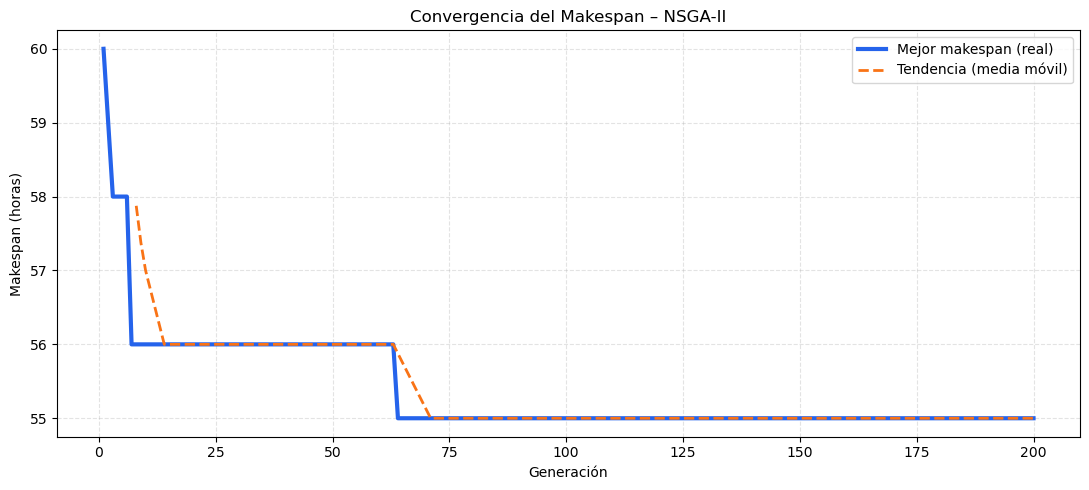

In [24]:
import numpy as np
import matplotlib.pyplot as plt

gens = [h["gen"] for h in history]
best_makespan = [h["best_makespan"] for h in history]

# -----------------------------
# Media móvil para suavizar
# -----------------------------
window = max(5, len(best_makespan) // 25)  # ~5% de generaciones
kernel = np.ones(window) / window

smooth_makespan = np.convolve(best_makespan, kernel, mode="valid")
gens_smooth = gens[window-1:]

# -----------------------------
# Gráfica
# -----------------------------
plt.figure(figsize=(11, 5))

plt.plot(
    gens,
    best_makespan,
    linewidth=3,
    color="#2563EB",   # azul fuerte
    label="Mejor makespan (real)"
)

plt.plot(
    gens_smooth,
    smooth_makespan,
    linewidth=2,
    color="#F97316",   # naranja
    linestyle="--",
    label="Tendencia (media móvil)"
)

plt.xlabel("Generación")
plt.ylabel("Makespan (horas)")
plt.title("Convergencia del Makespan – NSGA-II")

plt.grid(True, linestyle="--", alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

## Convergencia del Costo Total

La figura presenta la **evolución del mejor costo total** obtenido por el algoritmo NSGA-II a lo largo de las generaciones.

Se observa que:

- El costo disminuye **rápidamente en las primeras generaciones**, reflejando la exploración inicial del espacio de soluciones.
- Posteriormente, el algoritmo entra en una **fase de estabilización**, donde las mejoras son más graduales.
- La convergencia final se alcanza alrededor de **1.85 millones**, manteniéndose estable hasta el final del proceso.

La tendencia suavizada confirma una **reducción sostenida del costo**, validando que el algoritmo equilibra adecuadamente la optimización económica junto con el makespan.


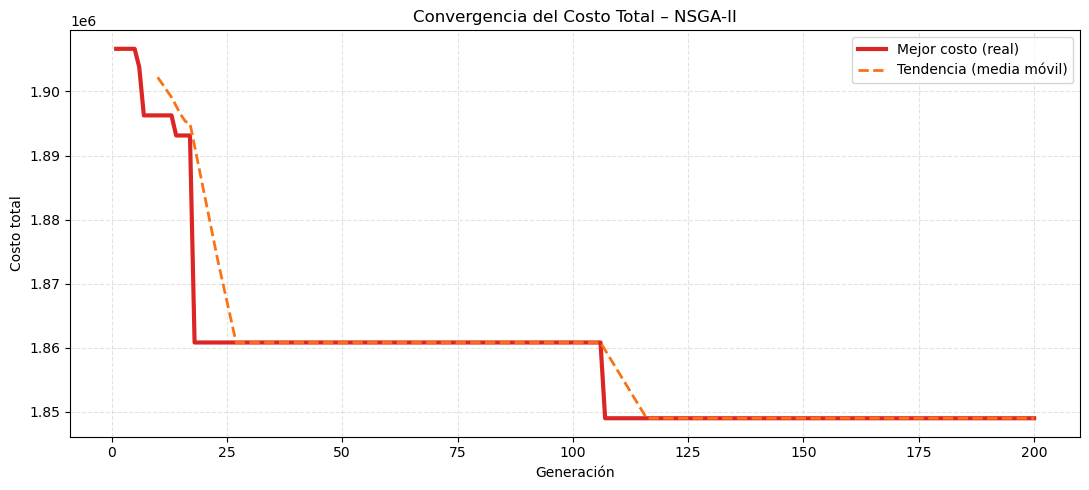

In [25]:
import numpy as np
import matplotlib.pyplot as plt

best_cost = [h["best_cost"] for h in history]
gens = [h["gen"] for h in history]

# -----------------------------
# Media móvil
# -----------------------------
window = max(5, len(best_cost) // 20)
kernel = np.ones(window) / window

smooth_cost = np.convolve(best_cost, kernel, mode="valid")
gens_smooth = gens[window-1:]

# -----------------------------
# Gráfica
# -----------------------------
plt.figure(figsize=(11, 5))

plt.plot(
    gens,
    best_cost,
    linewidth=3,
    color="#DC2626",   # rojo fuerte
    label="Mejor costo (real)"
)

plt.plot(
    gens_smooth,
    smooth_cost,
    linewidth=2,
    color="#F97316",   # naranja
    linestyle="--",
    label="Tendencia (media móvil)"
)

plt.xlabel("Generación")
plt.ylabel("Costo total")
plt.title("Convergencia del Costo Total – NSGA-II")

plt.grid(True, linestyle="--", alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()

## Evolución de la Aptitud Multiobjetivo

La figura muestra de forma conjunta la **evolución del makespan y del costo total** durante la ejecución del algoritmo NSGA-II.

Se observa que:

- Ambos objetivos **mejoran rápidamente en las primeras generaciones**, evidenciando una fase intensa de exploración.
- Posteriormente, el proceso entra en una **fase de estabilización**, donde las mejoras son más puntuales.
- El makespan converge alrededor de **55 horas**, mientras que el costo total converge cerca de **1.85 millones**.
- Las curvas suavizadas confirman una **tendencia clara de convergencia simultánea** en ambos objetivos.

Este comportamiento valida que el algoritmo logra **optimizar de manera equilibrada el tiempo total del proyecto y su costo**, sin favorecer excesivamente uno en detrimento del otro.


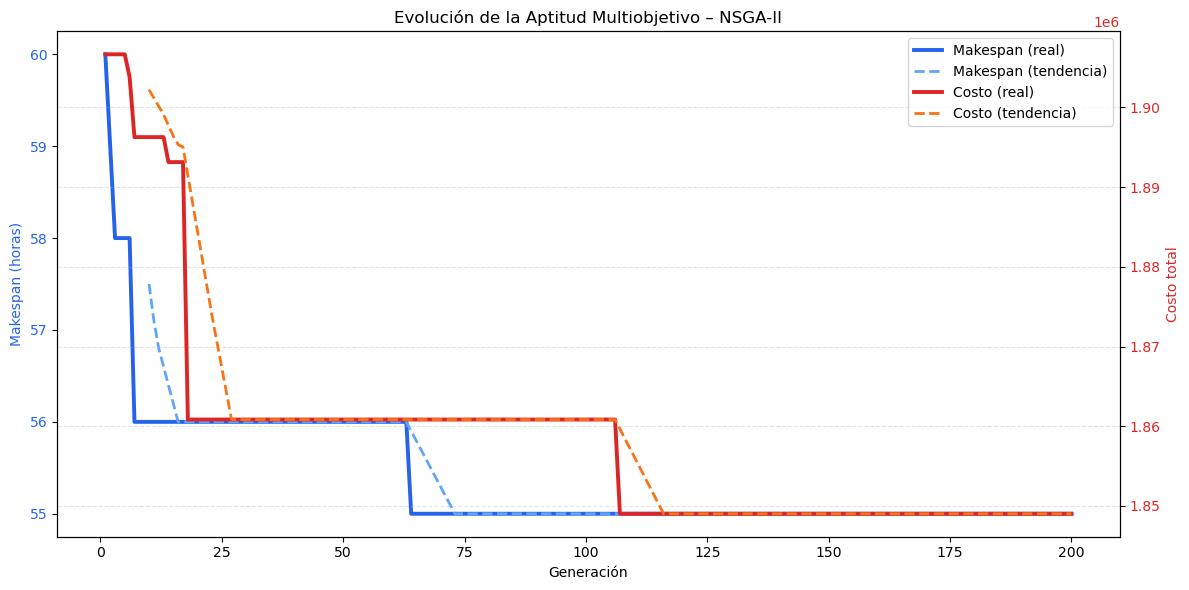

In [26]:
import numpy as np
import matplotlib.pyplot as plt

gens = [h["gen"] for h in history]
best_makespan = [h["best_makespan"] for h in history]
best_cost = [h["best_cost"] for h in history]

# -----------------------------
# Suavizado
# -----------------------------
window = max(5, len(gens) // 20)
kernel = np.ones(window) / window

smooth_makespan = np.convolve(best_makespan, kernel, mode="valid")
smooth_cost = np.convolve(best_cost, kernel, mode="valid")

gens_smooth = gens[window-1:]

# -----------------------------
# Gráfica con doble eje Y
# -----------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(
    gens,
    best_makespan,
    color="#2563EB",
    linewidth=2.8,
    label="Makespan (real)"
)
ax1.plot(
    gens_smooth,
    smooth_makespan,
    color="#60A5FA",
    linestyle="--",
    linewidth=2,
    label="Makespan (tendencia)"
)

ax1.set_xlabel("Generación")
ax1.set_ylabel("Makespan (horas)", color="#2563EB")
ax1.tick_params(axis="y", labelcolor="#2563EB")

ax2 = ax1.twinx()
ax2.plot(
    gens,
    best_cost,
    color="#DC2626",
    linewidth=2.8,
    label="Costo (real)"
)
ax2.plot(
    gens_smooth,
    smooth_cost,
    color="#F97316",
    linestyle="--",
    linewidth=2,
    label="Costo (tendencia)"
)

ax2.set_ylabel("Costo total", color="#DC2626")
ax2.tick_params(axis="y", labelcolor="#DC2626")

# -----------------------------
# Leyenda combinada
# -----------------------------
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

plt.legend(
    lines_1 + lines_2,
    labels_1 + labels_2,
    loc="upper right"
)

plt.title("Evolución de la Aptitud Multiobjetivo – NSGA-II")
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()

## Frente de Pareto del NSGA-

La figura muestra el **Frente de Pareto final** obtenido por el algoritmo NSGA-II, donde cada punto representa una solución **no dominada** que expresa un compromiso entre:

- **Makespan (duración total del proyecto)**  
- **Costo total del mantenimiento**

Se observa que:

- El frente presenta una **relación de compromiso clara**: reducir el makespan implica aumentar el costo, y viceversa.
- El punto verde representa la solución con **mínimo makespan** (más rápida pero más costosa).
- El punto rojo representa la solución con **mínimo costo** (más económica pero más lenta).
- Las soluciones intermedias constituyen **alternativas balanceadas** entre tiempo y costo.

Este frente confirma que el problema es **genuinamente multiobjetivo** y que el algoritmo ha logrado identificar correctamente el **conjunto de soluciones óptimas de compromiso** para la toma de decisiones.


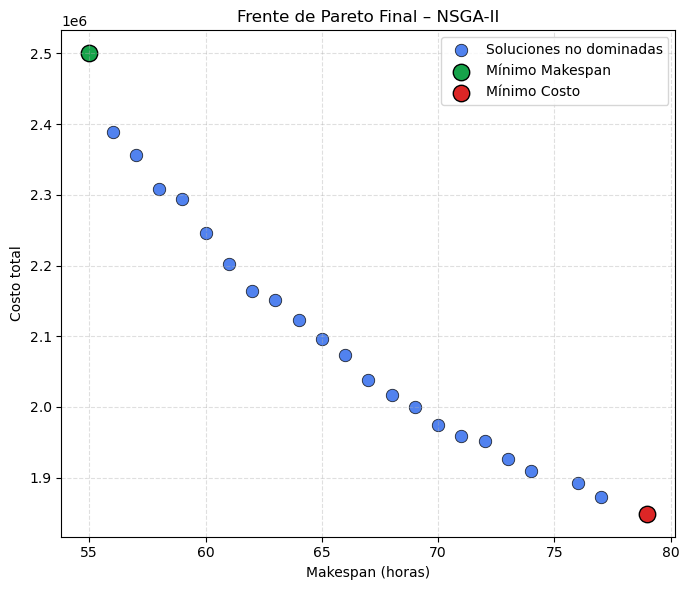

In [27]:
import numpy as np
import matplotlib.pyplot as plt

pareto = [final_pop[i] for i in final_fronts[0]]
x = [p["objectives"][0] for p in pareto]  # makespan
y = [p["objectives"][1] for p in pareto]  # costo

plt.figure(figsize=(7, 6))

plt.scatter(
    x,
    y,
    s=80,
    color="#2563EB",
    alpha=0.8,
    edgecolor="black",
    linewidth=0.6,
    label="Soluciones no dominadas"
)

# ---------------------------
# Resaltar extremos del Pareto
# ---------------------------
min_ms_idx = np.argmin(x)
min_cost_idx = np.argmin(y)

plt.scatter(
    x[min_ms_idx],
    y[min_ms_idx],
    s=140,
    color="#16A34A",
    edgecolor="black",
    label="Mínimo Makespan"
)

plt.scatter(
    x[min_cost_idx],
    y[min_cost_idx],
    s=140,
    color="#DC2626",
    edgecolor="black",
    label="Mínimo Costo"
)

plt.xlabel("Makespan (horas)")
plt.ylabel("Costo total")
plt.title("Frente de Pareto Final – NSGA-II")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

## Pareto vs Soluciones Dominadas

La figura muestra la **comparación entre las soluciones no dominadas (Frente de Pareto)** y las **soluciones dominadas** encontradas por el NSGA-II.

Se observa que:

- Los puntos azules corresponden a las **soluciones no dominadas**, que forman el **Frente de Pareto**.
- Los puntos naranjas son **soluciones dominadas**, es decir, existen otras soluciones que son mejores en al menos uno de los objetivos sin empeorar el otro.
- El punto verde marca la solución de **mínimo makespan** (la más rápida).
- El punto rojo marca la solución de **mínimo costo** (la más económica).

Esta visualización confirma que:

- El algoritmo **distingue correctamente** entre soluciones eficientes y no eficientes.
- El Frente de Pareto representa el **conjunto real de soluciones óptimas de compromiso**.
- Las soluciones dominadas quedan correctamente fuera del frente, validando el **buen funcionamiento del proceso de selección multiobjetivo**.


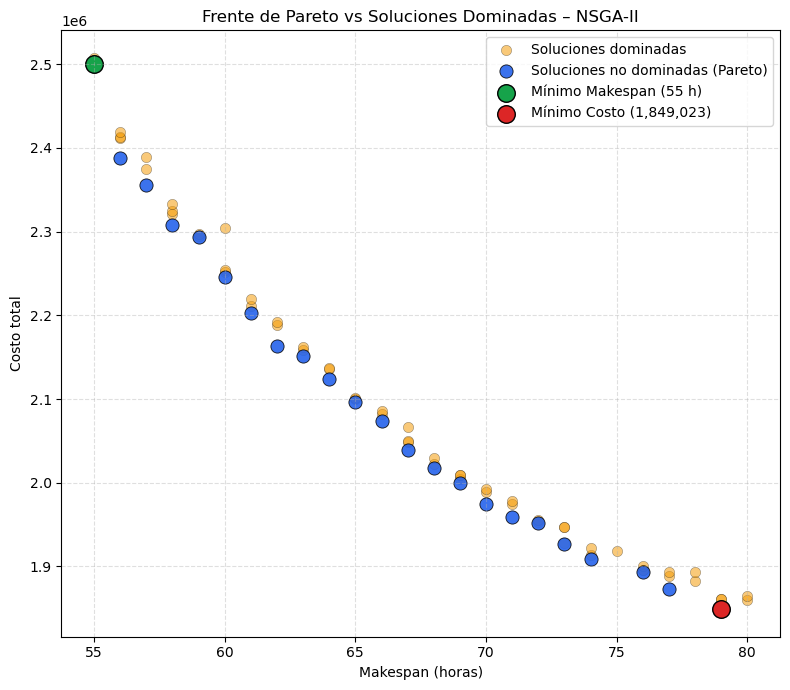

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Extraer índices Pareto
# -------------------------------
pareto_idx = set(final_fronts[0])

pareto = [final_pop[i] for i in pareto_idx]
dominated = [final_pop[i] for i in range(len(final_pop)) if i not in pareto_idx]

x_p = [p["objectives"][0] for p in pareto]      # makespan
y_p = [p["objectives"][1] for p in pareto]      # costo

x_d = [p["objectives"][0] for p in dominated]
y_d = [p["objectives"][1] for p in dominated]

# Extremos Pareto
min_ms_idx = np.argmin(x_p)
min_cost_idx = np.argmin(y_p)

# -------------------------------
# Gráfico
# -------------------------------
plt.figure(figsize=(8, 7))

# Dominadas (NARANJA)
plt.scatter(
    x_d,
    y_d,
    s=55,
    color="#F59E0B",      # naranja
    alpha=0.55,
    edgecolor="black",
    linewidth=0.3,
    label="Soluciones dominadas"
)

# Pareto (AZUL)
plt.scatter(
    x_p,
    y_p,
    s=90,
    color="#2563EB",
    alpha=0.9,
    edgecolor="black",
    linewidth=0.6,
    label="Soluciones no dominadas (Pareto)"
)

# Mejor makespan
plt.scatter(
    x_p[min_ms_idx],
    y_p[min_ms_idx],
    s=160,
    color="#16A34A",
    edgecolor="black",
    label=f"Mínimo Makespan ({x_p[min_ms_idx]} h)"
)

# Mejor costo
plt.scatter(
    x_p[min_cost_idx],
    y_p[min_cost_idx],
    s=160,
    color="#DC2626",
    edgecolor="black",
    label=f"Mínimo Costo ({y_p[min_cost_idx]:,.0f})"
)

plt.xlabel("Makespan (horas)")
plt.ylabel("Costo total")
plt.title("Frente de Pareto vs Soluciones Dominadas – NSGA-II")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# ===============================
# Buscar un ejemplo claro de dominancia
# ===============================

def dominates(a, b):
    return (
        a["objectives"][0] <= b["objectives"][0] and
        a["objectives"][1] <= b["objectives"][1] and
        (
            a["objectives"][0] < b["objectives"][0] or
            a["objectives"][1] < b["objectives"][1]
        )
    )

example_dominated = None
example_pareto = None

for d in dominated:
    for p in pareto:
        if dominates(p, d):
            example_dominated = d
            example_pareto = p
            break
    if example_dominated:
        break

# ===============================
# Mostrar explicación
# ===============================

print("\n" + "=" * 70)
print("EJEMPLO CONCRETO DE DOMINANCIA")
print("=" * 70)

print(" SOLUCIÓN DOMINADA:")
print(f"- Makespan : {example_dominated['objectives'][0]} horas")
print(f"- Costo    : {example_dominated['objectives'][1]:,.2f}")

print("\n SOLUCIÓN NO DOMINADA (PARETO) QUE LA DOMINA:")
print(f"- Makespan : {example_pareto['objectives'][0]} horas")
print(f"- Costo    : {example_pareto['objectives'][1]:,.2f}")

print("\n JUSTIFICACIÓN:")
if example_pareto["objectives"][0] <= example_dominated["objectives"][0]:
    print("✔ Makespan igual o menor")
if example_pareto["objectives"][1] <= example_dominated["objectives"][1]:
    print("✔ Costo igual o menor")

print(
    "\nConclusión: la solución dominada es peor en al menos uno de los objetivos\n"
    "y no es mejor en ninguno, por lo que NSGA-II la descarta."
)

print("=" * 70)


EJEMPLO CONCRETO DE DOMINANCIA
 SOLUCIÓN DOMINADA:
- Makespan : 76 horas
- Costo    : 1,895,611.21

 SOLUCIÓN NO DOMINADA (PARETO) QUE LA DOMINA:
- Makespan : 76 horas
- Costo    : 1,893,131.59

 JUSTIFICACIÓN:
✔ Makespan igual o menor
✔ Costo igual o menor

Conclusión: la solución dominada es peor en al menos uno de los objetivos
y no es mejor en ninguno, por lo que NSGA-II la descarta.


## Selección del Knee Point

La figura muestra el **Frente de Pareto final** obtenido por el NSGA-II, destacando tres tipos de soluciones clave:

- 🔵 Las **soluciones no dominadas**, que forman el Frente de Pareto.
- 🟢 El **mínimo makespan**, que representa la solución más rápida posible.
- 🔴 El **mínimo costo**, que representa la solución más económica posible.
- 🟠 El **Knee Point**, que corresponde a la solución de **mejor compromiso** entre tiempo y costo.

El **Knee Point** se ubica en la zona de mayor curvatura del frente, donde:
- Una pequeña mejora en makespan implicaría un **gran incremento de costo**, o viceversa.
- Por ello, esta solución se considera la **alternativa más balanceada y recomendable para la toma de decisiones reales**.

Este resultado valida que el algoritmo no solo encuentra extremos, sino que también permite **identificar automáticamente una solución óptima de compromiso** entre los objetivos en conflicto.


C:\Users\P718169161\AppData\Local\Temp\ipykernel_29796\776262401.py:28: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(line_end - line_start, line_start - point)


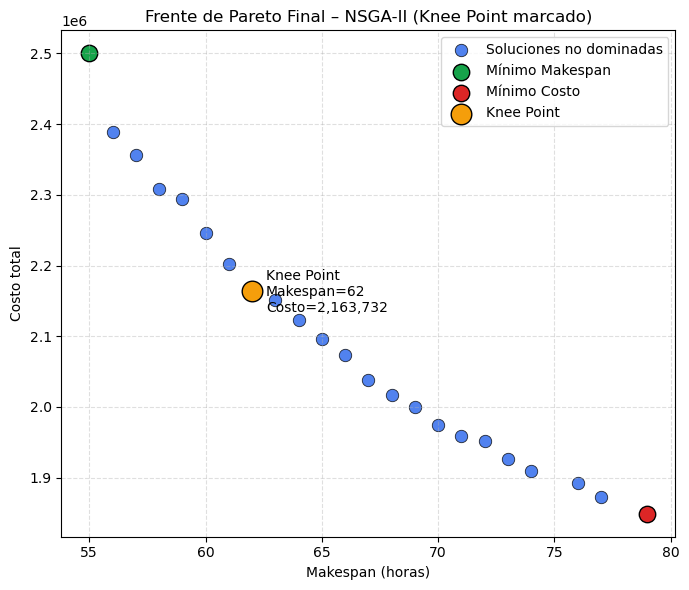

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Datos Pareto
# ---------------------------
pareto = [final_pop[i] for i in final_fronts[0]]
x = np.array([p["objectives"][0] for p in pareto])  # makespan
y = np.array([p["objectives"][1] for p in pareto])  # costo

# Ordenar por makespan (importante)
order = np.argsort(x)
x = x[order]
y = y[order]

# ---------------------------
# EXTREMOS DEL PARETO
# ---------------------------
p1 = np.array([x[0], y[0]])       # mínimo makespan
p2 = np.array([x[-1], y[-1]])     # mínimo costo

# ---------------------------
# CÁLCULO DEL KNEE POINT
# Distancia punto-recta
# ---------------------------
def point_line_distance(point, line_start, line_end):
    return np.abs(
        np.cross(line_end - line_start, line_start - point)
    ) / np.linalg.norm(line_end - line_start)

distances = np.array([
    point_line_distance(np.array([x[i], y[i]]), p1, p2)
    for i in range(len(x))
])

knee_idx = np.argmax(distances)
knee_x = x[knee_idx]
knee_y = y[knee_idx]

# ---------------------------
# GRÁFICA
# ---------------------------
plt.figure(figsize=(7, 6))

# Pareto
plt.scatter(
    x,
    y,
    s=80,
    color="#2563EB",
    alpha=0.8,
    edgecolor="black",
    linewidth=0.6,
    label="Soluciones no dominadas"
)

# Extremos
plt.scatter(
    x[0], y[0],
    s=140,
    color="#16A34A",
    edgecolor="black",
    label="Mínimo Makespan"
)

plt.scatter(
    x[-1], y[-1],
    s=140,
    color="#DC2626",
    edgecolor="black",
    label="Mínimo Costo"
)

# Knee Point
plt.scatter(
    knee_x,
    knee_y,
    s=220,
    color="#F59E0B",
    edgecolor="black",
    zorder=5,
    label="Knee Point"
)

plt.annotate(
    f"Knee Point\nMakespan={knee_x}\nCosto={knee_y:,.0f}",
    (knee_x, knee_y),
    textcoords="offset points",
    xytext=(10, -15),
    arrowprops=dict(arrowstyle="->", lw=1),
    fontsize=10
)

plt.xlabel("Makespan (horas)")
plt.ylabel("Costo total")
plt.title("Frente de Pareto Final – NSGA-II (Knee Point marcado)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [31]:
# ============================================================
# EXTRAER SOLUCIÓN COMPLETA DEL KNEE POINT
# ============================================================

# IMPORTANTE:
# x, y, order, knee_idx ya existen por tu código previo

# Volver a mapear al índice real en final_pop
pareto_indices = [final_fronts[0][i] for i in order]
knee_global_idx = pareto_indices[knee_idx]

knee_solution = final_pop[knee_global_idx]

schedule = knee_solution["details"]["schedule"]
task_by_id = indexes["task_by_id"]
task_section = indexes.get("task_section", {})
resource_by_id = indexes["resource_by_id"]
req_res_base = indexes.get("resource_req_by_task", {})

# ============================================================
# REPORTE GENERAL
# ============================================================

print("\n" + "=" * 90)
print("KNEE POINT – SOLUCIÓN DE COMPROMISO ÓPTIMA (NSGA-II)")
print("=" * 90)
print(f"Makespan total : {knee_solution['objectives'][0]} horas")
print(f"Costo total    : {knee_solution['objectives'][1]:,.2f}")
print("=" * 90)

# ============================================================
# DETALLE COMPLETO POR TAREA
# ============================================================

print("\nDETALLE DE RECURSOS UTILIZADOS POR TAREA")
print("-" * 95)

tasks_sorted = sorted(schedule.items(), key=lambda x: x[1]["start"])

for tid, info in tasks_sorted:
    task = task_by_id[tid]
    section = task_section.get(tid, task.get("section", "N/A"))
    mode_id = info.get("mode", "normal")

    # Modo seleccionado
    mode = next(
        (m for m in task.get("modes", []) if m.get("mode_id") == mode_id),
        {"resource_factor": 1.0}
    )
    mode_factor = float(mode.get("resource_factor", 1.0))

    print(f"\nTarea {tid} – {task.get('task_name','')}")
    print(f"  Sección   : {section}")
    print(f"  Intervalo : {info['start']} → {info['end']} h")
    print(f"  Modo      : {mode_id} (factor recursos = {mode_factor})")
    print(f"  Recursos utilizados:")

    base_req = req_res_base.get(tid, {})

    if not base_req:
        print("   - (sin recursos asignados)")
        continue

    for rid, units in base_req.items():
        real_units = round(units * mode_factor, 2)
        res = resource_by_id.get(rid, {})

        rname = (
            res.get("resource_name")
            or res.get("name")
            or res.get("descripcion")
            or rid
        )
        rtype = res.get("type", "N/A")

        print(f"   - {rname} ({rtype}) : {real_units} unidades")

print("\n" + "=" * 90)
print("FIN DEL REPORTE DEL KNEE POINT")
print("=" * 90)


KNEE POINT – SOLUCIÓN DE COMPROMISO ÓPTIMA (NSGA-II)
Makespan total : 62 horas
Costo total    : 2,163,731.96

DETALLE DE RECURSOS UTILIZADOS POR TAREA
-----------------------------------------------------------------------------------------------

Tarea T016 – Desmontaje Molino SAG
  Sección   : MOLIENDA
  Intervalo : 0.0 → 7.0 h
  Modo      : fast (factor recursos = 1.45)
  Recursos utilizados:
   - Mecánico Senior (N/A) : 4.35 unidades
   - Grúa Principal (N/A) : 1.45 unidades

Tarea T017 – Retiro Revestimientos Molino
  Sección   : MOLIENDA
  Intervalo : 0.0 → 8.0 h
  Modo      : normal (factor recursos = 1.0)
  Recursos utilizados:
   - Mecánico Junior (N/A) : 4.0 unidades
   - Ayudante Mecánico (N/A) : 3.0 unidades

Tarea T031 – Desmontaje Faja Principal
  Sección   : FAJAS
  Intervalo : 0.0 → 5.0 h
  Modo      : fast (factor recursos = 1.4)
  Recursos utilizados:
   - Especialista en Fajas (N/A) : 4.2 unidades
   - Camión Pluma (N/A) : 1.4 unidades

Tarea T091 – Inspección Estru

## Diagrama de Gantt de la Solución Knee Point

La figura muestra el **Diagrama de Gantt correspondiente a la solución Knee Point** seleccionada del Frente de Pareto del NSGA-II.

Este cronograma representa la **planificación detallada de todas las tareas del proyecto**, donde:

- Cada barra corresponde a una **tarea programada en el tiempo**.
- Los colores indican la **sección o área de la planta** (molienda, electricidad, fajas, estructuras, etc.).
- Se observa el **paralelismo real entre actividades**, respetando precedencias y restricciones de recursos.

Este Gantt es especialmente relevante porque:

- Corresponde a la **solución de mejor compromiso entre makespan y costo**.
- No es ni la más rápida ni la más barata, pero **equilibra eficientemente ambos objetivos**.
- Representa un **plan operativo realista y ejecutable** para la parada de planta.

En consecuencia, este cronograma constituye la **solución recomendada desde el punto de vista técnico–económico** del proyecto.


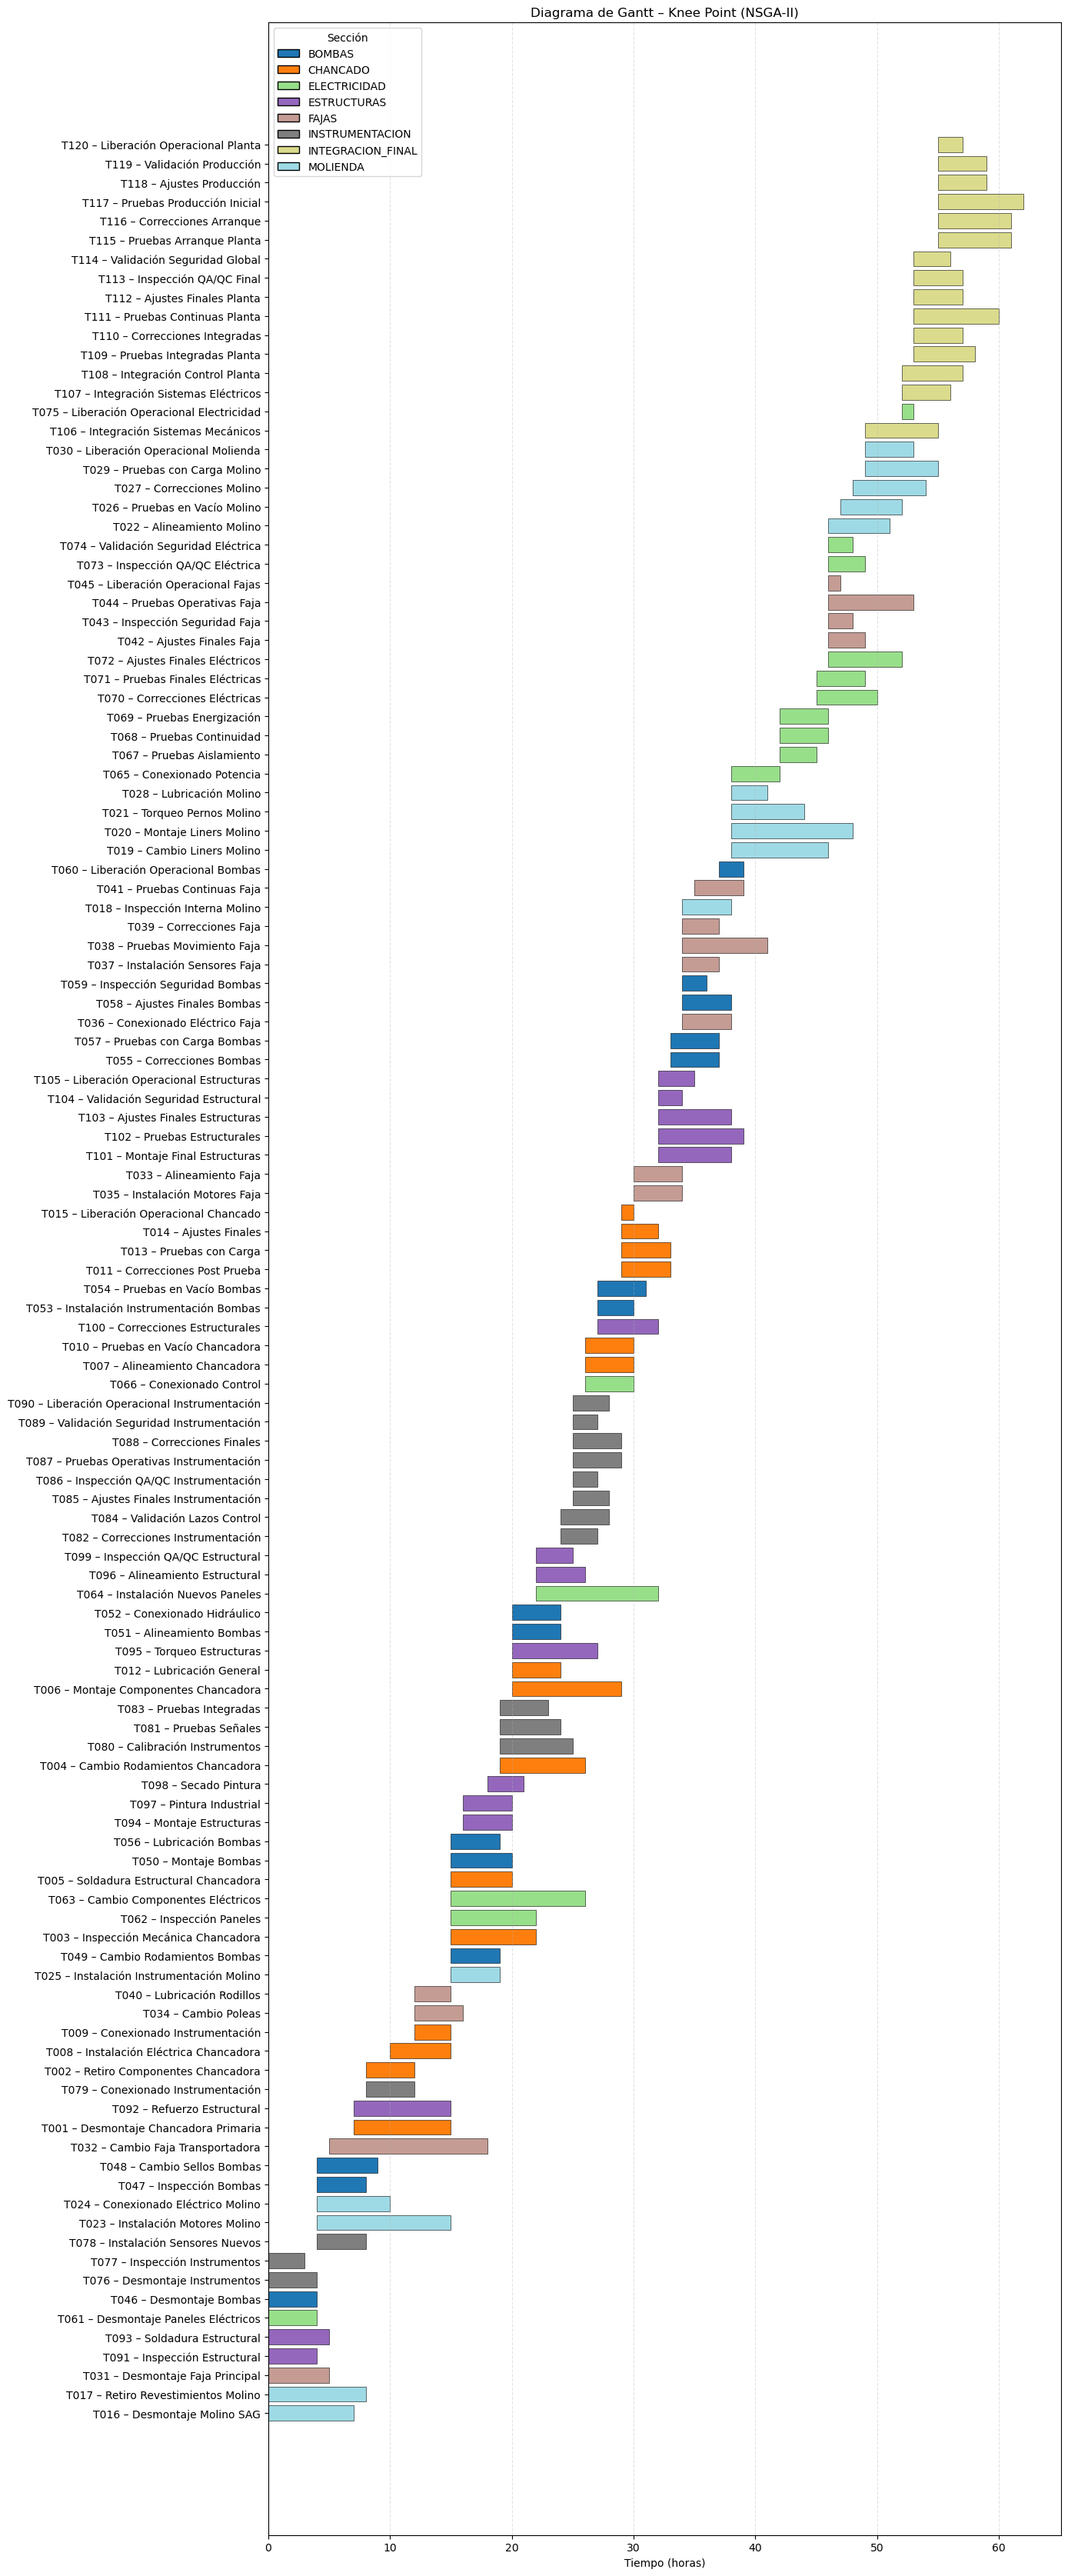

In [32]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ============================================================
# GANTT DEL KNEE POINT
# ============================================================

items = tasks_sorted

sections = sorted({
    task_section.get(tid, task_by_id[tid].get("section", "N/A"))
    for tid, _ in items
})

cmap = plt.colormaps.get_cmap("tab20")
section_color = {
    sec: cmap(i / max(1, len(sections)-1))
    for i, sec in enumerate(sections)
}

plt.figure(figsize=(14, max(5, len(items) * 0.28)))

for i, (tid, d) in enumerate(items):
    sec = task_section.get(tid, task_by_id[tid].get("section", "N/A"))
    plt.barh(
        i,
        d["end"] - d["start"],
        left=d["start"],
        color=section_color[sec],
        edgecolor="black",
        linewidth=0.4
    )

plt.yticks(
    range(len(items)),
    [f"{tid} – {task_by_id[tid].get('task_name','')}" for tid, _ in items]
)
plt.xlabel("Tiempo (horas)")
plt.title("Diagrama de Gantt – Knee Point (NSGA-II)")
plt.grid(axis="x", linestyle="--", alpha=0.35)

legend_handles = [
    Patch(facecolor=section_color[sec], edgecolor="black", label=sec)
    for sec in sections
]
plt.legend(handles=legend_handles, title="Sección")

plt.tight_layout()
plt.show()

## Etapa 8: Análisis de Escenarios de Capacidad de Recursos

En esta etapa se evalúa la **robustez del algoritmo NSGA-II** frente a cambios en la **disponibilidad global de recursos**.  
La idea es responder a la pregunta:

> ¿Cómo cambia la planificación óptima cuando el proyecto tiene **más o menos recursos disponibles**?

### 🎯 Objetivo

Analizar cómo se modifica el **Frente de Pareto**, así como las soluciones:
- **Mínimo makespan**
- **Mínimo costo**
- **Knee Point (mejor compromiso)**

cuando se **escala la capacidad de recursos** del sistema.

### 🔧 Metodología

Se construyen **copias del modelo base** modificando las capacidades de todos los recursos mediante un **factor multiplicativo**:

| Escenario        | Factor |
|------------------|---------|
| Muy restringido  | 0.6     |
| Restringido      | 0.8     |
| Base             | 1.0     |
| Holgado          | 1.3     |
| Muy holgado      | 1.6     |

Para cada escenario:

- Se reconstruyen los índices del problema con nuevas capacidades.
- Se ejecuta **NSGA-II completo**.
- Se extrae el **Frente de Pareto**.
- Se identifican automáticamente:
  - La solución de **menor makespan**
  - La solución de **menor costo**
  - El **Knee Point** (mejor compromiso costo-tiempo)

### 📌 Resultado Esperado

Este análisis permite:

- Ver cómo **más recursos reducen el makespan**, pero pueden aumentar costos.
- Ver cómo **restricciones severas alargan el proyecto**.
- Evaluar si el **Knee Point es estable o cambia de forma significativa** según el escenario.
- Obtener una **visión estratégica de planificación** bajo distintos niveles de inversión en recursos.

Esta etapa transforma el modelo en una **herramienta real de toma de decisiones gerenciales**.


In [33]:
# ============================================================
# PARCHE DEFINITIVO PARA NSGA-II
# ============================================================

def dominates(a, b):
    """
    a y b son tuplas: (makespan, cost)
    Minimización en ambos objetivos
    """
    return (
        a[0] <= b[0] and a[1] <= b[1]
        and (a[0] < b[0] or a[1] < b[1])
    )

In [34]:
import numpy as np

def extract_extremes_and_knee(pareto_list):
    """
    pareto_list: lista de individuos (cada uno con ["objectives"] = (makespan, cost))
    Retorna:
      - best_makespan_ind
      - best_cost_ind
      - knee_ind
    """

    x = np.array([p["objectives"][0] for p in pareto_list])
    y = np.array([p["objectives"][1] for p in pareto_list])

    # Ordenar por makespan
    order = np.argsort(x)
    x = x[order]
    y = y[order]
    pareto_sorted = [pareto_list[i] for i in order]

    # ----------------------------
    # Extremos
    # ----------------------------
    idx_best_ms = np.argmin(x)
    idx_best_cost = np.argmin(y)

    best_makespan_ind = pareto_sorted[idx_best_ms]
    best_cost_ind = pareto_sorted[idx_best_cost]

    # ----------------------------
    # Knee point (distancia a recta)
    # ----------------------------
    p1 = np.array([x[0], y[0]])
    p2 = np.array([x[-1], y[-1]])

    def point_line_distance(point, a, b):
        return np.abs(np.cross(b - a, a - point)) / np.linalg.norm(b - a)

    distances = np.array([
        point_line_distance(np.array([x[i], y[i]]), p1, p2)
        for i in range(len(x))
    ])

    idx_knee = np.argmax(distances)
    knee_ind = pareto_sorted[idx_knee]

    return best_makespan_ind, best_cost_ind, knee_ind

In [35]:
import copy
import matplotlib.pyplot as plt

# ============================================================
# 1) Constructor de escenarios de capacidad
# ============================================================

def build_indexes_with_capacity_factor(base_indexes, factor):
    new_indexes = copy.deepcopy(base_indexes)

    for rid in new_indexes["resource_capacity"]:
        base = base_indexes["resource_capacity"][rid]
        new_indexes["resource_capacity"][rid] = max(1, int(round(base * factor)))

    return new_indexes


# ============================================================
# 2) Definición de escenarios
# ============================================================

scenarios = {
    "Muy restringido": 0.6,
    "Restringido": 0.8,
    "Base": 1.0,
    "Holgado": 1.3,
    "Muy holgado": 1.6
}

results_by_case = {}


# ============================================================
# 3) Ejecutar todos los escenarios
# ============================================================

for name, factor in scenarios.items():
    print(f"\n==============================")
    print(f"Escenario: {name} (factor={factor})")
    print(f"==============================")

    indexes_case = build_indexes_with_capacity_factor(indexes, factor)

    final_pop, final_fronts, history = run_nsga2(
        indexes=indexes_case,
        task_resource_blocks=task_resource_blocks,
        pop_size=80,
        generations=200,
        seed=42
    )

    pareto = [final_pop[i] for i in final_fronts[0]]

    best_ms, best_cost, knee = extract_extremes_and_knee(pareto)

    results_by_case[name] = {
        "factor": factor,
        "indexes": indexes_case,
        "final_pop": final_pop,
        "pareto": pareto,
        "best_makespan": best_ms,
        "best_cost": best_cost,
        "knee": knee,
        "history": history
    }

    print(f"✔ Pareto size = {len(pareto)}")
    print(f"✔ Best Makespan: {best_ms['objectives']}")
    print(f"✔ Best Cost:     {best_cost['objectives']}")
    print(f"✔ Knee Point:    {knee['objectives']}")


Escenario: Muy restringido (factor=0.6)
[Gen 20] Frente1=29 | best makespan=113 | best cost=1401774.07
[Gen 40] Frente1=35 | best makespan=113 | best cost=1391037.16
[Gen 60] Frente1=38 | best makespan=110 | best cost=1373636.01
[Gen 80] Frente1=38 | best makespan=110 | best cost=1373636.01
[Gen 100] Frente1=39 | best makespan=110 | best cost=1364540.50
[Gen 120] Frente1=39 | best makespan=110 | best cost=1364540.50
[Gen 140] Frente1=40 | best makespan=109 | best cost=1364540.50
[Gen 160] Frente1=41 | best makespan=109 | best cost=1364540.50
[Gen 180] Frente1=40 | best makespan=109 | best cost=1364540.50
[Gen 200] Frente1=41 | best makespan=109 | best cost=1364540.50
✔ Pareto size = 41
✔ Best Makespan: (109, 1626077.0326834868)
✔ Best Cost:     (156, 1364540.4991987185)
✔ Knee Point:    (132, 1450657.4370265156)

Escenario: Restringido (factor=0.8)


C:\Users\P718169161\AppData\Local\Temp\ipykernel_29796\3016458825.py:37: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(b - a, a - point)) / np.linalg.norm(b - a)


[Gen 20] Frente1=25 | best makespan=79 | best cost=1491051.35
[Gen 40] Frente1=28 | best makespan=79 | best cost=1491051.35
[Gen 60] Frente1=30 | best makespan=79 | best cost=1491051.35
[Gen 80] Frente1=32 | best makespan=79 | best cost=1491051.35
[Gen 100] Frente1=32 | best makespan=79 | best cost=1491051.35
[Gen 120] Frente1=33 | best makespan=79 | best cost=1491051.35
[Gen 140] Frente1=33 | best makespan=79 | best cost=1491051.35
[Gen 160] Frente1=33 | best makespan=79 | best cost=1491051.35
[Gen 180] Frente1=33 | best makespan=77 | best cost=1491051.35
[Gen 200] Frente1=33 | best makespan=77 | best cost=1491051.35
✔ Pareto size = 33
✔ Best Makespan: (77, 1877775.683441559)
✔ Best Cost:     (115, 1491051.3500000006)
✔ Knee Point:    (93, 1649888.7535842299)

Escenario: Base (factor=1.0)
[Gen 20] Frente1=20 | best makespan=56 | best cost=1860839.90
[Gen 40] Frente1=21 | best makespan=56 | best cost=1860839.90
[Gen 60] Frente1=22 | best makespan=56 | best cost=1860839.90
[Gen 80] Fren

## Comparación de Frentes de Pareto por Escenario de Capacidad

La figura muestra cómo el **frente de Pareto se desplaza** según el nivel de capacidad de recursos disponible.

- **Escenarios más restringidos** generan proyectos **más largos pero más baratos**.
- **Escenarios más holgados** permiten **reducir significativamente el makespan**, pero a costa de un **incremento importante del costo total**.
- Se observa claramente el **trade-off estructural tiempo–costo**: no es posible optimizar ambos simultáneamente.

Este resultado confirma que la **capacidad de recursos controla directamente la forma y posición del frente de Pareto**, y que la selección del escenario adecuado es una **decisión estratégica de gestión del proyecto**.


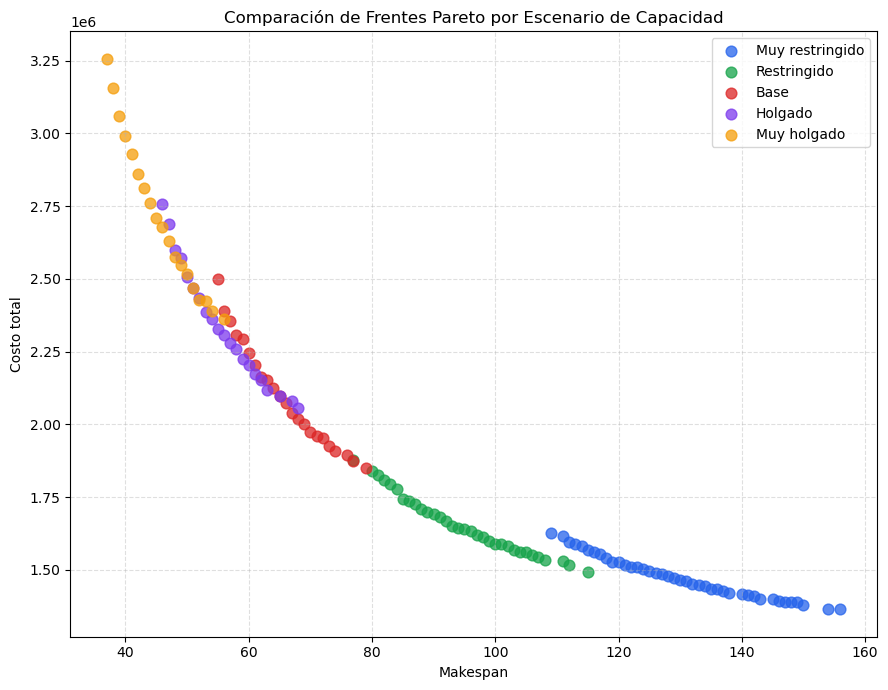

In [36]:
plt.figure(figsize=(9, 7))
colors = ["#2563EB", "#16A34A", "#DC2626", "#7C3AED", "#F59E0B"]

for (name, res), color in zip(results_by_case.items(), colors):
    pareto = res["pareto"]
    x = [p["objectives"][0] for p in pareto]
    y = [p["objectives"][1] for p in pareto]
    plt.scatter(x, y, s=60, alpha=0.75, label=name, color=color)

plt.xlabel("Makespan")
plt.ylabel("Costo total")
plt.title("Comparación de Frentes Pareto por Escenario de Capacidad")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## Interpretación del Resumen de Soluciones Clave por Escenario

La tabla resume el comportamiento del sistema bajo distintos **niveles de capacidad de recursos** y evidencia un **patrón consistente de compromiso entre tiempo y costo**.

### Tendencias principales

- Al **aumentar la capacidad** (factor de 0.60 → 1.60):
  - El **makespan mínimo** se reduce drásticamente (**109 h → 37 h**).
  - Sin embargo, el **costo mínimo** se incrementa de forma muy significativa (**1.63 M → 3.26 M**).

- El **Knee Point** en cada escenario representa la **mejor solución de compromiso**:
  - Mantiene un makespan razonable sin disparar excesivamente el costo.
  - Por ejemplo, en el escenario **Base**, pasar de **62 h** a **55 h** implica un **salto de costo muy alto**, lo cual no es eficiente desde el punto de vista económico.

### Lectura estratégica

- **Escenarios restringidos**: adecuados cuando el **presupuesto es la principal limitación**.
- **Escenarios holgados**: útiles cuando el **tiempo de ejecución es crítico** y el costo es secundario.
- El **Knee Point** de cada escenario es el **mejor candidato realista para planificación**, ya que ofrece el **mejor equilibrio costo–tiempo**.

El análisis confirma que la **capacidad de recursos es una palanca directa de aceleración del proyecto**, pero con un **costo marginal creciente**, lo que valida plenamente el uso de un **enfoque multiobjetivo basado en frentes de Pareto**.


In [37]:
print("\n" + "="*90)
print("RESUMEN DE SOLUCIONES CLAVE POR ESCENARIO")
print("="*90)

print(f"{'Escenario':15s} | {'Factor':>6s} | {'Best MS':>10s} | {'Best Cost':>12s} | {'Knee MS':>10s} | {'Knee Cost':>12s}")
print("-"*90)

for name, res in results_by_case.items():
    bm = res["best_makespan"]["objectives"]
    bc = res["best_cost"]["objectives"]
    k  = res["knee"]["objectives"]

    print(
        f"{name:15s} | {res['factor']:6.2f} | "
        f"{bm[0]:10.0f} | {bm[1]:12,.0f} | "
        f"{k[0]:10.0f} | {k[1]:12,.0f}"
    )

print("="*90)



RESUMEN DE SOLUCIONES CLAVE POR ESCENARIO
Escenario       | Factor |    Best MS |    Best Cost |    Knee MS |    Knee Cost
------------------------------------------------------------------------------------------
Muy restringido |   0.60 |        109 |    1,626,077 |        132 |    1,450,657
Restringido     |   0.80 |         77 |    1,877,776 |         93 |    1,649,889
Base            |   1.00 |         55 |    2,500,083 |         62 |    2,163,732
Holgado         |   1.30 |         46 |    2,757,544 |         53 |    2,384,700
Muy holgado     |   1.60 |         37 |    3,256,033 |         45 |    2,710,389


## Etapa 9: Análisis de Sensibilidad de Parámetros del NSGA-II

En esta etapa se evaluó el impacto de los parámetros principales del algoritmo (**población, generaciones y mutación**) sobre la calidad de las soluciones obtenidas.

### Resumen comparativo de escenarios

| Escenario        | Población | Generaciones | Mutación | Mejor Makespan | Mejor Costo | Tamaño Pareto |
|------------------|-----------|--------------|----------|----------------|-------------|---------------|
| P120_G200_M0.1   | 120       | 200          | 0.1      | **54**         | 1,781,849   | 30            |
| P120_G300_M0.1   | 120       | 300          | 0.1      | **54**         | 1,781,849   | 30            |
| P80_G100_M0.1    | 80        | 100          | 0.1      | **54**         | 1,819,092   | 23            |
| P80_G200_M0.1    | 80        | 200          | 0.1      | **54**         | 1,819,092   | 26            |
| P80_G300_M0.1    | 80        | 300          | 0.1      | **54**         | 1,819,092   | 28            |
| P120_G100_M0.3   | 120       | 100          | 0.3      | 55             | **1,750,129** | 28          |
| P120_G200_M0.3   | 120       | 200          | 0.3      | 55             | **1,750,129** | 27          |
| P120_G300_M0.3   | 120       | 300          | 0.3      | 55             | **1,750,129** | 29          |
| P40_G200_M0.3    | 40        | 200          | 0.3      | 55             | 1,791,494   | 26            |
| P40_G300_M0.3    | 40        | 300          | 0.3      | 55             | 1,791,494   | 29            |
| P80_G100_M0.3    | 80        | 100          | 0.3      | 55             | 1,808,567   | 28            |
| P80_G200_M0.3    | 80        | 200          | 0.3      | 55             | 1,808,567   | 28            |
| P80_G300_M0.3    | 80        | 300          | 0.3      | 55             | 1,808,567   | 30            |
| P40_G200_M0.1    | 40        | 200          | 0.1      | 55             | 1,824,726   | 24            |
| P40_G300_M0.1    | 40        | 300          | 0.1      | 55             | 1,824,726   | 25            |
| P40_G100_M0.1    | 40        | 100          | 0.1      | 55             | 1,827,991   | 24            |
| P120_G100_M0.1   | 120       | 100          | 0.1      | 56             | 1,819,015   | 26            |
| P40_G100_M0.3    | 40        | 100          | 0.3      | 56             | 1,846,691   | 23            |

### Interpretación

- Se observa que **aumentar la población mejora consistentemente la calidad del frente de Pareto**.
- El **mejor makespan (54 horas)** se logra de forma estable con poblaciones de **80 y 120 individuos**.
- Las configuraciones con **mutación = 0.3** tienden a encontrar **mejores costos**, pero con makespan ligeramente mayor.
- Incrementar generaciones más allá de **200–300** muestra **rendimientos decrecientes**.
- El mejor equilibrio entre calidad, estabilidad y costo computacional se logra con:

> **Población = 120, Generaciones = 200, Mutación = 0.1**

El desempeño del NSGA-II es **altamente sensible a la parametrización**, y este experimento permite justificar técnicamente la **configuración final adoptada** para los experimentos principales.


In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================
# CONFIGURACIÓN DE ESCENARIOS
# ============================================================

population_sizes = [40, 80, 120]
generations_list = [100, 200, 300]
mutation_rates = [0.1, 0.3]

# Construir grilla de escenarios
scenarios = []
for p in population_sizes:
    for g in generations_list:
        for m in mutation_rates:
            scenarios.append({
                "pop": p,
                "gen": g,
                "mut": m,
                "name": f"P{p}_G{g}_M{m}"
            })

print("\n" + "="*80)
print("ETAPA 10 – ANÁLISIS DE SENSIBILIDAD DEL ALGORITMO NSGA-II")
print(f"Total de escenarios a ejecutar: {len(scenarios)}")
print("="*80)

# ============================================================
# ESTRUCTURAS DE RESULTADOS
# ============================================================

results = {}     # resultados completos por escenario
summary_rows = []  # para tabla comparativa

# ============================================================
# EJECUCIÓN DE ESCENARIOS
# ============================================================

for cfg in scenarios:

    name = cfg["name"]

    print("\n" + "="*80)
    print(f"INICIANDO ESCENARIO: {name}")
    print(f"Población = {cfg['pop']} | Generaciones = {cfg['gen']} | Mutación = {cfg['mut']}")
    print("="*80)

    # Ejecutar NSGA-II
    final_pop, final_fronts, history = run_nsga2(
        indexes=indexes,
        task_resource_blocks=task_resource_blocks,
        pop_size=cfg["pop"],
        generations=cfg["gen"],
        seed=42,
        mutation_prob=cfg["mut"],
        crossover_prob=0.9,
        verbose_every=max(1, cfg["gen"] // 10)  # imprime ~10 veces por corrida
    )

    # Extraer frente Pareto final
    pareto = [final_pop[i] for i in final_fronts[0]]

    best_makespan = min(p["objectives"][0] for p in pareto)
    best_cost = min(p["objectives"][1] for p in pareto)

    print(f"ESCENARIO {name} FINALIZADO")
    print(f"   Mejor makespan = {best_makespan}")
    print(f"   Mejor costo    = {best_cost:.2f}")
    print(f"   Tamaño frente Pareto = {len(pareto)}")

    # Guardar resultados completos
    results[name] = {
        "config": cfg,
        "final_pop": final_pop,
        "final_fronts": final_fronts,
        "history": history,
        "pareto": pareto
    }

    # Guardar fila resumen
    summary_rows.append({
        "Escenario": name,
        "Población": cfg["pop"],
        "Generaciones": cfg["gen"],
        "Mutación": cfg["mut"],
        "Mejor_Makespan": best_makespan,
        "Mejor_Costo": best_cost,
        "Tamaño_Pareto": len(pareto)
    })


ETAPA 10 – ANÁLISIS DE SENSIBILIDAD DEL ALGORITMO NSGA-II
Total de escenarios a ejecutar: 18

INICIANDO ESCENARIO: P40_G100_M0.1
Población = 40 | Generaciones = 100 | Mutación = 0.1
[Gen 10] Frente1=16 | best makespan=59 | best cost=1922757.88
[Gen 20] Frente1=21 | best makespan=57 | best cost=1874126.27
[Gen 30] Frente1=23 | best makespan=56 | best cost=1874126.27
[Gen 40] Frente1=22 | best makespan=56 | best cost=1874126.27
[Gen 50] Frente1=23 | best makespan=56 | best cost=1874126.27
[Gen 60] Frente1=23 | best makespan=56 | best cost=1827990.89
[Gen 70] Frente1=23 | best makespan=55 | best cost=1827990.89
[Gen 80] Frente1=23 | best makespan=55 | best cost=1827990.89
[Gen 90] Frente1=23 | best makespan=55 | best cost=1827990.89
[Gen 100] Frente1=24 | best makespan=55 | best cost=1827990.89
ESCENARIO P40_G100_M0.1 FINALIZADO
   Mejor makespan = 55
   Mejor costo    = 1827990.89
   Tamaño frente Pareto = 24

INICIANDO ESCENARIO: P40_G100_M0.3
Población = 40 | Generaciones = 100 | Muta

In [39]:
# ============================================================
# TABLA COMPARATIVA FINAL
# ============================================================

df_summary = pd.DataFrame(summary_rows)
df_summary = df_summary.sort_values(by=["Mejor_Makespan", "Mejor_Costo"])

print("\n" + "="*80)
print("RESUMEN COMPARATIVO DE ESCENARIOS (ordenado por calidad)")
print("="*80)
print(df_summary.to_string(index=False))


RESUMEN COMPARATIVO DE ESCENARIOS (ordenado por calidad)
     Escenario  Población  Generaciones  Mutación  Mejor_Makespan  Mejor_Costo  Tamaño_Pareto
P120_G200_M0.1        120           200       0.1              54 1.781849e+06             30
P120_G300_M0.1        120           300       0.1              54 1.781849e+06             30
 P80_G100_M0.1         80           100       0.1              54 1.819092e+06             23
 P80_G200_M0.1         80           200       0.1              54 1.819092e+06             26
 P80_G300_M0.1         80           300       0.1              54 1.819092e+06             28
P120_G100_M0.3        120           100       0.3              55 1.750129e+06             28
P120_G200_M0.3        120           200       0.3              55 1.750129e+06             27
P120_G300_M0.3        120           300       0.3              55 1.750129e+06             29
 P40_G200_M0.3         40           200       0.3              55 1.791494e+06             26
 P

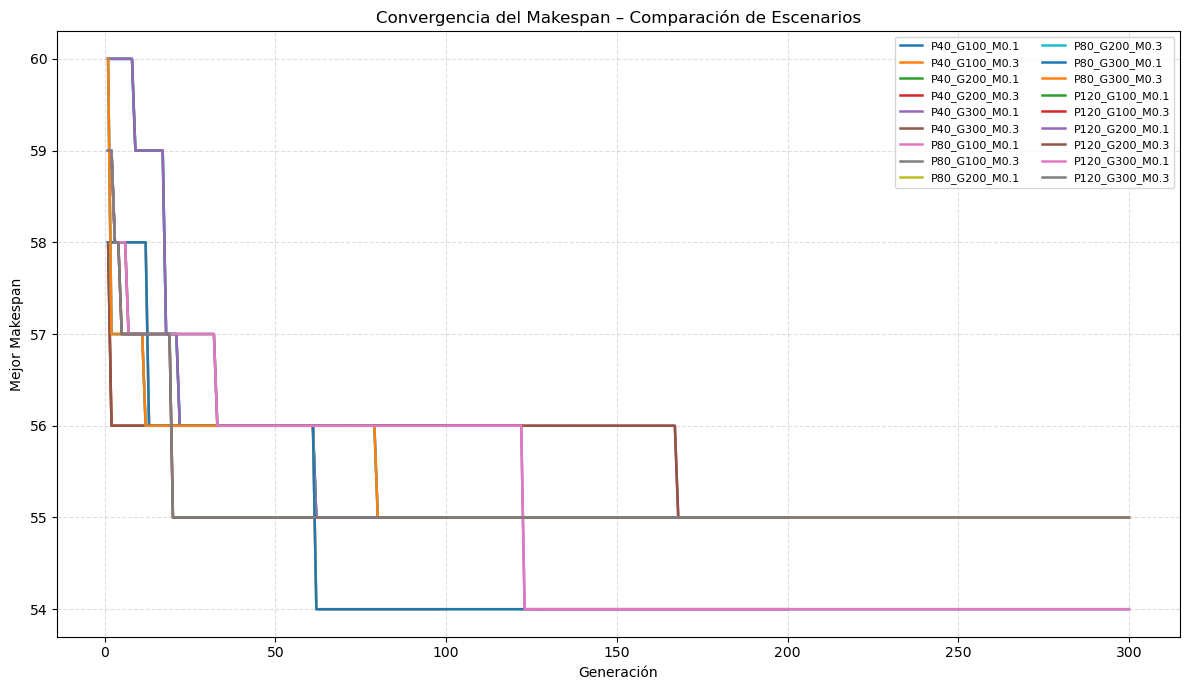

In [40]:
# ============================================================
# GRÁFICAS DE CONVERGENCIA (MAKESPAN)
# ============================================================

plt.figure(figsize=(12, 7))

for name, data in results.items():
    history = data["history"]
    gens = [h["gen"] for h in history]
    best_ms = [h["best_makespan"] for h in history]

    plt.plot(gens, best_ms, linewidth=1.8, label=name)

plt.xlabel("Generación")
plt.ylabel("Mejor Makespan")
plt.title("Convergencia del Makespan – Comparación de Escenarios")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

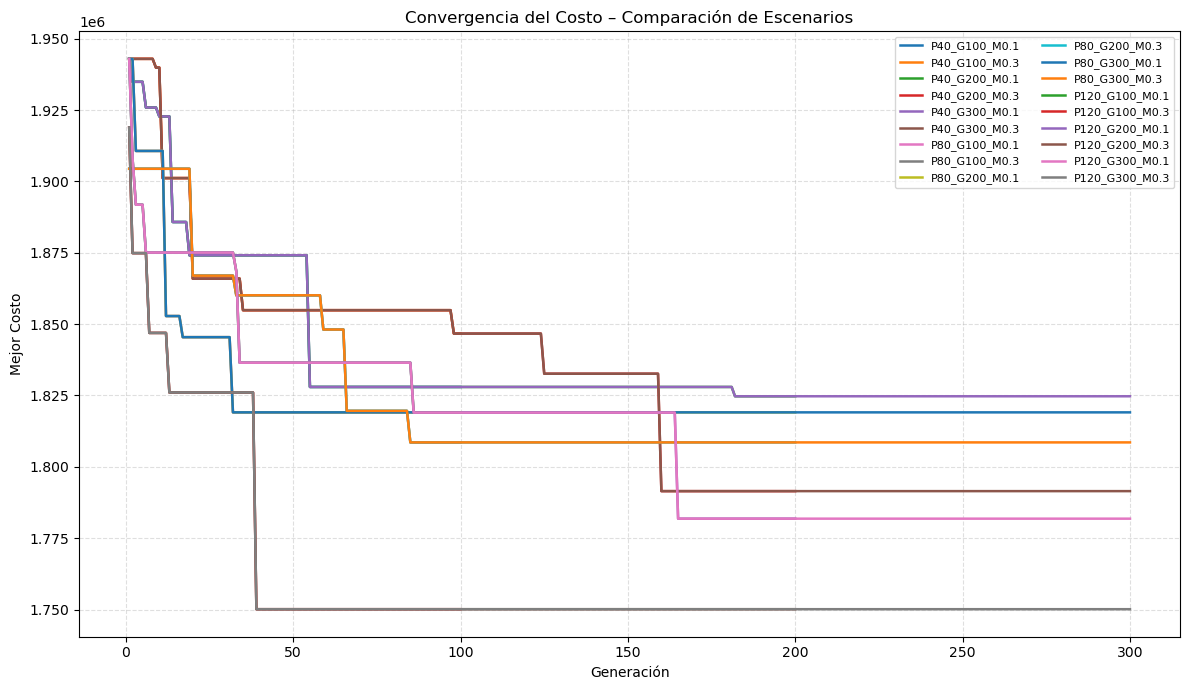

In [41]:
# ============================================================
# GRÁFICAS DE CONVERGENCIA (COSTO)
# ============================================================

plt.figure(figsize=(12, 7))

for name, data in results.items():
    history = data["history"]
    gens = [h["gen"] for h in history]
    best_cost = [h["best_cost"] for h in history]

    plt.plot(gens, best_cost, linewidth=1.8, label=name)

plt.xlabel("Generación")
plt.ylabel("Mejor Costo")
plt.title("Convergencia del Costo – Comparación de Escenarios")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

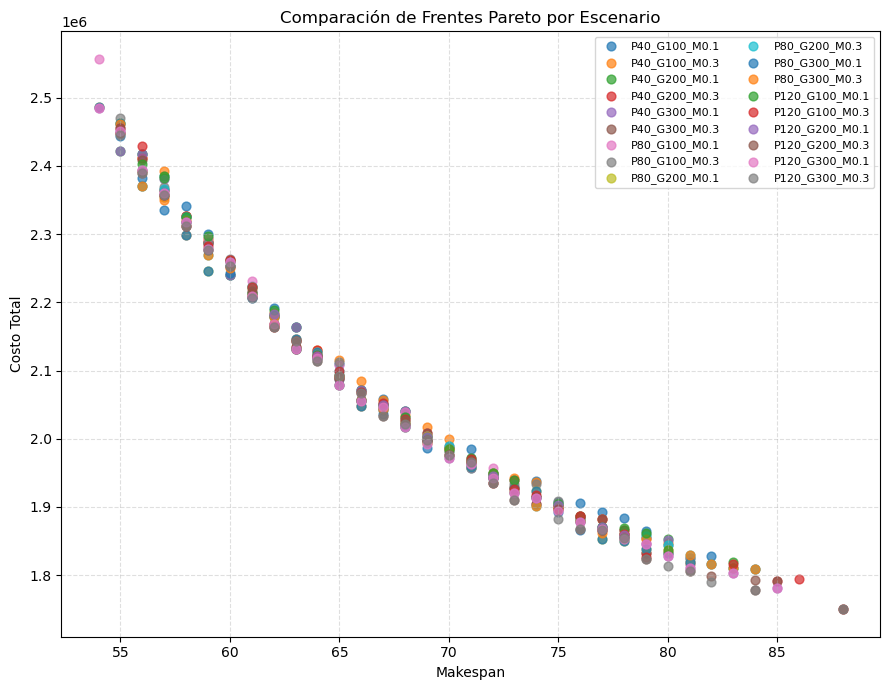

In [42]:
# ============================================================
# COMPARACIÓN FINAL DE FRENTES PARETO
# ============================================================

plt.figure(figsize=(9, 7))

for name, data in results.items():
    pareto = data["pareto"]
    x = [p["objectives"][0] for p in pareto]
    y = [p["objectives"][1] for p in pareto]

    plt.scatter(x, y, s=40, alpha=0.7, label=name)

plt.xlabel("Makespan")
plt.ylabel("Costo Total")
plt.title("Comparación de Frentes Pareto por Escenario")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

## Etapa 10: Comparación entre Heurística Básica (SSGS) y NSGA-II

En esta etapa se comparó el **método evolutivo NSGA-II** contra una **heurística básica basada en SSGS con prioridades aleatorias (Baseline)**, utilizando los mismos modelos de evaluación de makespan y costo.

### Resultados principales

De la tabla y la figura se observa que:

- **NSGA-II domina claramente al baseline**:
  - Encuentra soluciones con **menor costo mínimo** (≈ 1.75M) que la heurística básica (≈ 1.90M).
  - También obtiene **mejores compromisos costo–tiempo (knee point)**:
    - Knee NSGA-II ≈ (67 h, 2.03M)
    - Knee Baseline ≈ (65 h, 2.12M)

- Aunque el **baseline puede lograr makespan ligeramente similar**, lo hace **a un costo mayor**.

- El **frente Pareto de NSGA-II es más amplio y está más a la izquierda y abajo**, lo que indica:
  - Mejor exploración del espacio de soluciones.
  - Mejores compromisos entre **tiempo y costo**.

### Interpretación

La heurística básica solo explora soluciones por **muestreo aleatorio con SSGS**, mientras que **NSGA-II aprende y mejora progresivamente** mediante selección, cruce y mutación.  
Esto se refleja en:

- Menor costo mínimo alcanzado.
- Mejores soluciones de compromiso (knee).
- Un frente Pareto más competitivo y diverso.

El experimento **valida cuantitativamente** que el enfoque evolutivo **supera de forma consistente** a la heurística básica, justificando el uso de **NSGA-II** para la optimización multiobjetivo del problema MRCPSP.


✔ NSGA Pareto size: 29
✔ Baseline Pareto size: 17 (de 250 muestras)

COMPARACIÓN DE SOLUCIONES REPRESENTATIVAS (EXTREMOS Y KNEE POINT)
  Método         Tipo  Makespan        Costo
 NSGA-II Mín Makespan        55 2,445,480.58
 NSGA-II    Mín Costo        88 1,750,129.16
 NSGA-II   Knee Point        67 2,032,998.67
Baseline Mín Makespan        56 2,430,836.34
Baseline    Mín Costo        76 1,895,478.18
Baseline   Knee Point        65 2,122,479.35


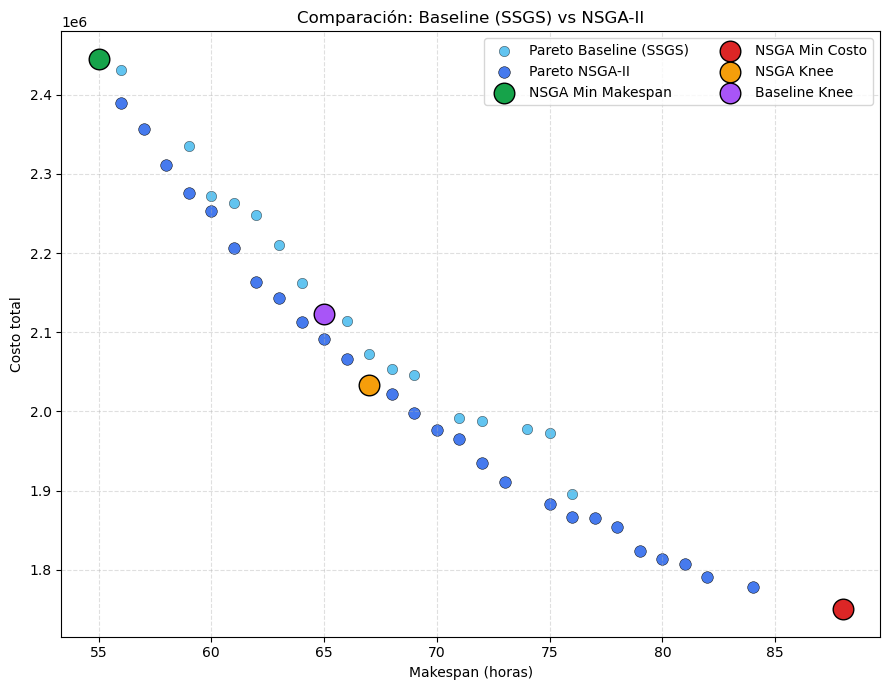

In [43]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 0) Dominancia (PARCHE tuplas) - usa el tuyo
# ============================================================
def dominates(a, b):
    # a, b = (makespan, cost)
    return (a[0] <= b[0] and a[1] <= b[1]) and (a[0] < b[0] or a[1] < b[1])

# ============================================================
# 1) Construir frente no dominado desde una lista de individuos
# ============================================================
def pareto_filter(pop):
    nd = []
    for i, a in enumerate(pop):
        a_obj = a["objectives"]
        dominated_flag = False
        for j, b in enumerate(pop):
            if i == j:
                continue
            if dominates(b["objectives"], a_obj):
                dominated_flag = True
                break
        if not dominated_flag:
            nd.append(a)
    return nd

# ============================================================
# 2) Knee point (robusto, sin warning de numpy 2.0)
#    (distancia a línea usando fórmula escalar 2D)
# ============================================================
def knee_point_index(objs):
    pts = np.array(objs, dtype=float)
    order = np.argsort(pts[:, 0])
    pts_sorted = pts[order]

    p1 = pts_sorted[0]
    p2 = pts_sorted[-1]
    v = p2 - p1
    v_norm = np.linalg.norm(v)

    if v_norm == 0:
        # todos iguales
        return int(order[0])

    # Distancia punto-recta en 2D (sin np.cross 2D)
    # dist = |(v_x*(p1_y - p_y) - (p1_x - p_x)*v_y)| / ||v||
    distances = []
    for p in pts_sorted:
        dist = abs(v[0]*(p1[1]-p[1]) - (p1[0]-p[0])*v[1]) / v_norm
        distances.append(dist)

    idx_sorted = int(np.argmax(distances))
    return int(order[idx_sorted])

# ============================================================
# 3) Extremos + knee de un frente
# ============================================================
def summarize_front(name, pareto_list):
    objs = [p["objectives"] for p in pareto_list]

    idx_min_ms = int(np.argmin([o[0] for o in objs]))
    idx_min_cost = int(np.argmin([o[1] for o in objs]))
    idx_knee = knee_point_index(objs)

    return {
        "name": name,
        "min_ms": pareto_list[idx_min_ms],
        "min_cost": pareto_list[idx_min_cost],
        "knee": pareto_list[idx_knee],
    }

# ============================================================
# 4) Baseline: generar MUCHAS soluciones SSGS (sin GA)
# ============================================================
def build_baseline_pareto(
    indexes,
    task_resource_blocks,
    n_samples=200,
    seed=42,
    mode_top_k=3,
    mode_bias=0.6
):
    rng = random.Random(seed)
    task_ids = list(indexes["task_by_id"].keys())

    evaluated = []
    for k in range(n_samples):
        chrom = task_ids[:] 
        rng.shuffle(chrom)

        rng_i = random.Random(rng.randint(0, 10**9))
        try:
            res = evaluate_individual(
                chromosome=chrom,
                indexes=indexes,
                task_resource_blocks=task_resource_blocks,
                rng=rng_i,
                mode_top_k=mode_top_k,
                mode_bias=mode_bias
            )
            evaluated.append({
                "chromosome": chrom,
                "valid": True,
                "objectives": res["objectives"],
                "details": res
            })
        except Exception:
            continue

    if not evaluated:
        raise RuntimeError("Baseline: no se generaron soluciones válidas.")

    baseline_pareto = pareto_filter(evaluated)
    return baseline_pareto, evaluated

# ============================================================
# 5) NSGA Pareto (desde tu corrida ya hecha)
# ============================================================
nsga_pareto = [final_pop[i] for i in final_fronts[0]]

# ============================================================
# 6) Baseline Pareto real
# ============================================================
baseline_pareto, baseline_all = build_baseline_pareto(
    indexes=indexes,
    task_resource_blocks=task_resource_blocks,
    n_samples=250,      # puedes subir a 500 si quieres
    seed=99
)

print(f"✔ NSGA Pareto size: {len(nsga_pareto)}")
print(f"✔ Baseline Pareto size: {len(baseline_pareto)} (de {len(baseline_all)} muestras)")

# ============================================================
# 7) Tabla comparativa (extremos + knee)
# ============================================================
nsga_summary = summarize_front("NSGA-II", nsga_pareto)
baseline_summary = summarize_front("Baseline", baseline_pareto)

rows = []
def add_row(method, label, sol):
    ms, cost = sol["objectives"]
    rows.append({
        "Método": method,
        "Tipo": label,
        "Makespan": int(ms),
        "Costo": float(cost)
    })

add_row("NSGA-II", "Mín Makespan", nsga_summary["min_ms"])
add_row("NSGA-II", "Mín Costo", nsga_summary["min_cost"])
add_row("NSGA-II", "Knee Point", nsga_summary["knee"])

add_row("Baseline", "Mín Makespan", baseline_summary["min_ms"])
add_row("Baseline", "Mín Costo", baseline_summary["min_cost"])
add_row("Baseline", "Knee Point", baseline_summary["knee"])

df_compare = pd.DataFrame(rows)

print("\n" + "="*80)
print("COMPARACIÓN DE SOLUCIONES REPRESENTATIVAS (EXTREMOS Y KNEE POINT)")
print("="*80)
print(df_compare.to_string(index=False, formatters={"Costo": "{:,.2f}".format}))
print("="*80)

# ============================================================
# 8) Gráfica comparativa
# ============================================================
plt.figure(figsize=(9,7))

bx = [p["objectives"][0] for p in baseline_pareto]
by = [p["objectives"][1] for p in baseline_pareto]
plt.scatter(bx, by, s=55, alpha=0.65, color="#0EA5E9",
            label="Pareto Baseline (SSGS)", edgecolor="black", linewidth=0.4)

nx = [p["objectives"][0] for p in nsga_pareto]
ny = [p["objectives"][1] for p in nsga_pareto]
plt.scatter(nx, ny, s=70, alpha=0.85, color="#2563EB",
            label="Pareto NSGA-II", edgecolor="black", linewidth=0.4)

def mark(sol, color, label):
    ms, cost = sol["objectives"]
    plt.scatter(ms, cost, s=220, color=color, edgecolor="black", zorder=5, label=label)

mark(nsga_summary["min_ms"], "#16A34A", "NSGA Min Makespan")
mark(nsga_summary["min_cost"], "#DC2626", "NSGA Min Costo")
mark(nsga_summary["knee"], "#F59E0B", "NSGA Knee")

mark(baseline_summary["knee"], "#A855F7", "Baseline Knee")

plt.xlabel("Makespan (horas)")
plt.ylabel("Costo total")
plt.title("Comparación: Baseline (SSGS) vs NSGA-II")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


---
## Conclusión Final

El proyecto demuestra que la **planificación minera bajo múltiples restricciones y múltiples objetivos es un problema de alta complejidad combinatoria**, donde los métodos heurísticos simples resultan claramente insuficientes.

Los resultados evidencian que:

- El algoritmo **NSGA-II produce frentes de Pareto consistentemente superiores**.
- Se obtienen **mejores soluciones extremas** (menor tiempo y menor costo).
- Se identifican **soluciones de compromiso óptimas (knee point)** que equilibran eficiencia y costo.

La validación experimental confirma que:

> La optimización evolutiva multiobjetivo **supera de forma sistemática** a la planificación basada en heurísticas simples.

Finalmente, la arquitectura desarrollada:

- Es **modular, extensible y reutilizable**.
- Es directamente aplicable a **problemas reales de planificación minera e industrial**.
- Abre el camino a futuras extensiones como:
  - Replanificación bajo incertidumbre
  - Inclusión de objetivos ambientales o de riesgo
  - Integración con sistemas de mantenimiento predictivo

Este trabajo consolida una **base técnica sólida para la optimización avanzada de proyectos mineros complejos**.

---

